# Classifiying Jets at the LHC - Practical Machine Learning for Physicists

## Contents

1. [Introduction](#introduction)
2. [Theory](#theory)
3. [Data Processing](#process)
4. [Task 1: Jet Image Classifyer](#image)
5. [Task 2 Part 1: Images + Jet Features](#features)
6. [Extension 2: Only Features](#feat)
7. [Extension 1: ECAL & HCAL Images](#CAL)
8. [Extension 3: Combined Image and Feature Classifier](#All)
9. [Which Model is the Most Accurate?](#which)
10. [Task 2 Part 2: Which Classes of Events are Easiest to Seperate?](#sep)
11. [Further Study: PCA](#pca)

## 1. Introduction


This notebook aims to provide some machine learning techniques to classify jets from LHC proton proton collisions. With many millions of collisions occurring every second, machine learning is becoming increasingly prevalent in providing stat-of-the art tagging algorithms to efficiently and accurately classify these jets, which is important for studying and verifying models in particle physics. 

## 2. Theory

Theory behind collisions at the LHC, particle jets, how images are made, jet constituents and features.

The data used is the HLS4ML $\sqrt{s} = 13$TeV LHC proton-proton collision simulations, [available on Zenodo](https://zenodo.org/doi/10.5281/zenodo.3602253). Each h5 file consists of 10,000 jetImage images, 100x100 pixel image representations of azimuthal distance $\phi$ and psuedotapidity $\eta$, as well as 10,000 Electromagnetic and Hadronic Calorimeter (ECAL and HCAL) 100x100 pixel images. There are also 59 features for each image.

There are 5 types of particles initiating the jets, gluons, quarks, W, Z and top. The 10,000 images, features are roughly equally split between the 5 classes, and the dataframes are one hot encoded so the particle and its image and feature representations can be extracted.

## 3. Data Processing

### 3.1 Packages

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
import urllib.request
import os

mpl.rcParams['figure.max_open_warning'] = 0
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 16, 'font.family': 'serif', 'mathtext.fontset': 'stix'})

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import concatenate, Activation, Add, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
scaler = StandardScaler()
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

from scipy import interp
from itertools import cycle
import seaborn as sns

### 3.2 Functions

In [2]:
def get_data(filename):
    '''Function to extract data from h5 file from the UCL HEP website
    input: 
    filename: string, file path
    
    returns:
    normalised arrays of gluon, quark, w, z and top 100x100 jet images'''
    
    #Opening the h5 file

    #The name of the file we are looking at
    file = filename

    #Checking if the file already exists
    if not os.path.isfile(file):
        if not os.path.isdir('data/train'):
            os.makedirs('data/train')
        
    #If doesn't exist, copy the network object to a local file    
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/jetimage/'+file, file)
    
    
    #Opening the file with h5  
    df = h5py.File(file,'r')
    
    #Getting labels for each column
    labels = [label.decode('utf-8') for label in df['jetFeatureNames'][:] ]
    
    #Looking at the jet image column
    pJet = pd.DataFrame(np.array(df['jets']), columns = labels)
    
    #Only getting image data for each image when the particle type column is 1, e.g. when 'quark' column is
    # 1, that entire row is a quark type data, so add the image under column 'jets' to quark data
    data_g = pJet.drop(pJet[pJet.j_g ==0].index)
    data_q = pJet.drop(pJet[pJet.j_q ==0].index)
    data_w = pJet.drop(pJet[pJet.j_w ==0].index)
    data_z = pJet.drop(pJet[pJet.j_z ==0].index)
    data_t = pJet.drop(pJet[pJet.j_t ==0].index)
    
    #Turn the image into a numpy array
    gluon_img = df['jetImage'][:] * np.array(pJet['j_g'])[:, None, None]
    quark_img = df['jetImage'][:] * np.array(pJet['j_q'])[:, None, None]
    w_img = df['jetImage'][:] * np.array(pJet['j_w'])[:, None, None]
    z_img = df['jetImage'][:] * np.array(pJet['j_z'])[:, None, None]
    top_img = df['jetImage'][:] * np.array(pJet['j_t'])[:, None, None]
    
    #The arrays are same size and most images are blank, because each array is size 10,000 where for example,
    # if the image is a gluon, that corresponding row in quark image will be an array of 0's, so remove
    # all blank images and sum of each of the 5 resulting arrays will be 10,000. There's an approximately
    # 20% split of images in each category
    gluon_img = gluon_img[np.where(np.sum(gluon_img, axis=(1, 2)) != 0)[0]]
    quark_img = quark_img[np.where(np.sum(quark_img, axis=(1, 2)) != 0)[0]]
    w_img = w_img[np.where(np.sum(w_img, axis=(1, 2)) != 0)[0]]
    z_img = z_img[np.where(np.sum(z_img, axis=(1, 2)) != 0)[0]]
    top_img = top_img[np.where(np.sum(top_img, axis=(1, 2)) != 0)[0]]
    
    #Normalise all images
    for i in range(len(gluon_img)):
        gluon_img[i] = gluon_img[i] / np.max(gluon_img)
    for i in range(len(quark_img)):
        quark_img[i] = quark_img[i] / np.max(quark_img)
    for i in range(len(w_img)):
        w_img[i] = w_img[i] / np.max(w_img)
    for i in range(len(z_img)):
        z_img[i] = z_img[i] / np.max(z_img)
    for i in range(len(top_img)):
        top_img[i] = top_img[i] / np.max(top_img)
    
    return gluon_img, quark_img, w_img, z_img, top_img

def loss_acc(his, name):
    '''Function to plot the validationa and training loss and accuracy of a model
    inputs:
    his: the history data after using model.fit
    name: string for the name of the file plots are saved to'''
    
    n = np.size(his.history['accuracy']) #Plotting points
    
    fig, axs = plt.subplots(1, 2, figsize = (12, 6))
    
    #Accuracy
    axs[0].plot(np.arange(1, n + 1, 1), his.history['accuracy'], color = 'crimson', label = 'Training')
    axs[0].plot(np.arange(1, n + 1, 1), his.history['val_accuracy'], color='turquoise', label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc = 'best', frameon = False)
    plt.savefig(f'accuracy {name}.pdf')
    
    #Loss
    axs[1].plot(np.arange(1, n + 1, 1), his.history['loss'], color = 'crimson', label = 'Training')
    axs[1].plot(np.arange(1, n + 1, 1), his.history['val_loss'], color='turquoise', label = 'Validation')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    plt.savefig(f'loss {name}.pdf')
  
    print(f"The final accuracy was {his.history['accuracy'][-1]:.4f} and the final loss was {his.history['loss'][-1]:.4f}")
    
    
#def ROC(prob, name):
   # 
    #plt.figure()
    #plt.plot([0, 1], [0, 1], '--', color = 'black')
    #for i in range(5):
      #  FPR, TPR, thresholds = roc_curve(labels_test_binarised[:, i], prob[:, i])
     #   plt.plot(FPR, TPR, label = particle_types[i])
   # plt.xlim(0, 1)
   # plt.ylim(0, 1.1)
   # plt.xlabel('False positive rate')
   # plt.ylabel('True positive rate')
   # plt.title(f'ROC ({name})')
   # plt.legend(loc = 'best', frameon = False)
   # plt.savefig(f'ROC {name}.pdf')
    
def ROC(prob, name):
    '''Function to plot the ROC curve  and also return the TRP & FPR for each particle type
    inputs:
    prob: array or probabilities of each image being classified as each particle type, from using 
    model.predict on the testing images
    name: string for the name of the file plots are saved to'''
    
    #Initialise array for FPR & TPR
    roc_data = []
    
    plt.figure()
    plt.plot([0, 1], [0, 1], '--', color = 'black') #The y=x line
    
    for i, particle in enumerate(particle_types):
        FPR, TPR, thresholds = roc_curve(labels_test_binarised[:, i], prob[:, i])
        roc_auc = auc(FPR, TPR) 
        plt.plot(FPR, TPR, label=f'{particle} (AUC = {roc_auc:.3f})')
        
        roc_data.append({
            'particle': particle,
            'FPR': FPR,
            'TPR': TPR,
            'AUC': roc_auc
        })
    
    plt.xlim(0, 1)
    plt.ylim(0, 1.1)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC ({name})')
    plt.legend(loc = 'best', frameon = False)
    plt.savefig(f'ROC_{name}.pdf', bbox_inches='tight')
    
    return roc_data
    
    
def conf(prob, name):
    '''Function to plot the confusion matrix for each model
    inputs:
    prob: array or probabilities of each image being classified as each particle type, from using 
    model.predict on the testing images
    name: string for the name of the file plots are saved to
    returns:
    predicted_labels: array of what particle the model thinks each image belongs to, used for F1 score
    class_accuracies: array of length 5, accuracy for each particle'''
    
    predicted_labels = np.argmax(prob, axis=1) #For each image, what is the particle the model most likely
    #thinks it is?

    cm = confusion_matrix(labels_test, predicted_labels) #What actually is the image? Using the labels

    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_accuracies = cm.diagonal() / cm.sum(axis=1) #The main diagonals of the confusion matrix

    for i, accuracy in enumerate(class_accuracies):
        print(f"Accuracy for {particle_types[i]}: {accuracy:.2%}")
        
    plt.figure(figsize = (8, 6))
    ax = sns.heatmap(cm_normalised, annot = True, fmt= ".2%" , cmap = 'BuPu', xticklabels = particle_types, 
            yticklabels = particle_types)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'Confusion {name}.pdf', dpi = 1000)
    plt.show()
    
    return predicted_labels, class_accuracies
        
#The 8 files we will use
file_names = [
    'data/train/jetImage_1_100p_10000_20000.h5',
    'data/train/jetImage_1_100p_20000_30000.h5',
    'data/train/jetImage_1_100p_30000_40000.h5',
    'data/train/jetImage_1_100p_40000_50000.h5',
    'data/train/jetImage_1_100p_50000_60000.h5',
    'data/train/jetImage_1_100p_60000_70000.h5',
    'data/train/jetImage_1_100p_70000_80000.h5',
    'data/train/jetImage_1_100p_80000_90000.h5'
]

particle_types = ['Gluon', 'Quark', 'W', 'Z', 'T']

Nepochs = 50

#Decided to not implement this
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               patience = 5, 
                               verbose = 0,
                               mode = 'max',
                               restore_best_weights = True)

## 4 Task 1: Jet Image Classifyer

### 4.1 Preparing Images

In [3]:
gluon_img_1, quark_img_1, w_img_1, z_img_1, top_img_1 = get_data('data/train/jetImage_1_100p_10000_20000.h5')
gluon_img_2, quark_img_2, w_img_2, z_img_2, top_img_2 = get_data('data/train/jetImage_1_100p_20000_30000.h5')
gluon_img_3, quark_img_3, w_img_3, z_img_3, top_img_3 = get_data('data/train/jetImage_1_100p_30000_40000.h5')
gluon_img_4, quark_img_4, w_img_4, z_img_4, top_img_4 = get_data('data/train/jetImage_1_100p_40000_50000.h5')
gluon_img_5, quark_img_5, w_img_5, z_img_5, top_img_5 = get_data('data/train/jetImage_1_100p_50000_60000.h5')
gluon_img_6, quark_img_6, w_img_6, z_img_6, top_img_6 = get_data('data/train/jetImage_1_100p_60000_70000.h5')
gluon_img_7, quark_img_7, w_img_7, z_img_7, top_img_7 = get_data('data/train/jetImage_1_100p_70000_80000.h5')
gluon_img_8, quark_img_8, w_img_8, z_img_8, top_img_8 = get_data('data/train/jetImage_1_100p_80000_90000.h5')

gluon_img = np.concatenate([gluon_img_1, gluon_img_2, gluon_img_3, gluon_img_4, gluon_img_5,
                            gluon_img_6, gluon_img_7, gluon_img_8])

quark_img = np.concatenate([quark_img_1, quark_img_2, quark_img_3, quark_img_4, quark_img_5,
                           quark_img_6, quark_img_7, quark_img_8])

w_img = np.concatenate([w_img_1, w_img_2, w_img_3, w_img_4, w_img_5,
                       w_img_6, w_img_7, w_img_8])

z_img = np.concatenate([z_img_1, z_img_2, z_img_3, z_img_4, z_img_5,
                       z_img_6, z_img_7, z_img_8])

top_img = np.concatenate([top_img_1, top_img_2, top_img_3, top_img_4, top_img_5,
                         top_img_6, top_img_7, top_img_8])

images = np.concatenate([gluon_img, quark_img, w_img, z_img, top_img])


def crop_center(img):
    '''Function to crop images from 100 x 100 to 40 x 40
    input: 
    img: image array
    returns:
    cropped image array'''
    height, width = img.shape
    startx = width//2 - 20 
    starty = height//2 - 20  
    return img[starty:starty+40, startx:startx+40]


def crop_images_center(images_array):
    '''Function to crop all the images
    input: 
    img: image array
    returns:
    cropped image array'''
    cropped_images = [crop_center(img) for img in images_array]
    return np.array(cropped_images)

# Crop all images in the dataset
images = crop_images_center(images)

# Reshape for CNN input
images = images.reshape(-1, 40, 40, 1)

# Creating binary labels for training and testing
labels = np.concatenate([np.full(np.size(gluon_img, axis = 0), 0), np.full(np.size(quark_img, axis = 0), 1),
                        np.full(np.size(w_img, axis = 0), 2), np.full(np.size(z_img, axis = 0), 3),
                        np.full(np.size(top_img, axis = 0), 4)])

In [4]:
#Splitting data 70% training, 15% validation and 15% testing
images_train, images_temp, labels_train, labels_temp = train_test_split(images, labels, test_size = 0.3,
                                                                       random_state = 69)

images_val, images_test, labels_val, labels_test = train_test_split(images_temp, labels_temp, test_size = 0.5,
                                                                    random_state = 69)

### 4.2 Training Model

In this model, we take the jet image representation and feed through a Convolutional Neural Network (CNN). The data is processed as follows:

The data is inputted with shape $ 40~(\text{height}) \times 40~(\text{width}) \times 1~(\text{channel[greyscale]})$

The convolutional layers, of size  $\text{K} = 3\times3$ and having 32 or 64 filters, reduce the size as follows

$$\text{W} = \text{H} = \frac{\text{W} - \text{K}}{\text{S}} + 1$$
H and W are the height and width, which are the same and S is the stride, which is 1. So the first convolutional layer here reduces the size to 

$$\text{W} = \frac{40-3}{1} + 1 = 38 \times 38 \times 32$$

where the 32 comes from the 32 filters.

The $2\times 2$ MaxPooling layers reduce the height and width by 2, so after the first MaxPooling layer the size is

$$19 \times 19 \times 32$$

After the third and final MaxPooling layer, we have

$$40\times40\times1 \rightarrow 3\times 3\times 64$$
which is flatted to a 1D array of size 576.

The dense layers, with different activation functions, feed foward the data, connected as neurons, reducing the dimensionality until it reaches a size of 5, for each class of event. The activation functions introduce non-linearity between the input and output enabling the model to learn and differentiate features. The ReLu (relu) activation function is defined as
$$\text{ReLu} = \max(0, x)$$

meaning for $x>0$ $x=x$ and $x=0$ otherwise. The Sigmoid $(\sigma(x))$ function is defined as

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$ and maps inputs to a range between 0 and 1, making it useful for probabilsitic outputs. Finally the Softmax function is defined as
$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}$$

It normalises the array of size 5 into a probability distribution of 5 outcomes, for each class.

In [5]:
model_1 = keras.Sequential([

    
    #3 Convolutional layers
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 40, 1)),

    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2, 2)),


    #Dropour to reduce overfitting
    keras.layers.Dropout(0.25),


    keras.layers.Flatten(),

    #Dense layers to reduce dimensionality
    keras.layers.Dense(256, activation='relu'),

    keras.layers.Dense(128, activation='sigmoid'),

    keras.layers.Dense(128, activation='relu'),

    keras.layers.Dense(64, activation='relu'),

    keras.layers.Dense(64, activation='sigmoid'),

    keras.layers.Dense(48, activation='sigmoid'),

    keras.layers.Dense(32, activation='relu'),

    keras.layers.Dense(16, activation='relu'),

    keras.layers.Dense(5, activation='softmax')

])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 19, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

In [6]:
model_1.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

history_1 = model_1.fit(images_train, labels_train, epochs = Nepochs,
                    validation_data = (images_val, labels_val), verbose = 1)

Epoch 1/50
1750/1750 [==============================] - 25s 14ms/step - loss: 1.1977 - accuracy: 0.5038 - val_loss: 1.0168 - val_accuracy: 0.6212
Epoch 2/50
1750/1750 [==============================] - 26s 15ms/step - loss: 1.0346 - accuracy: 0.6053 - val_loss: 0.9845 - val_accuracy: 0.6425
Epoch 3/50
1750/1750 [==============================] - 26s 15ms/step - loss: 0.9958 - accuracy: 0.6222 - val_loss: 0.9427 - val_accuracy: 0.6532
Epoch 4/50
1750/1750 [==============================] - 27s 15ms/step - loss: 0.9671 - accuracy: 0.6375 - val_loss: 0.9318 - val_accuracy: 0.6579
Epoch 5/50
1750/1750 [==============================] - 27s 15ms/step - loss: 0.9494 - accuracy: 0.6457 - val_loss: 0.9105 - val_accuracy: 0.6693
Epoch 6/50
1750/1750 [==============================] - 27s 15ms/step - loss: 0.9350 - accuracy: 0.6511 - val_loss: 0.8978 - val_accuracy: 0.6701
Epoch 7/50
1750/1750 [==============================] - 27s 16ms/step - loss: 0.9233 - accuracy: 0.6569 - val_loss: 0.8759 -

<IPython.core.display.Javascript object>


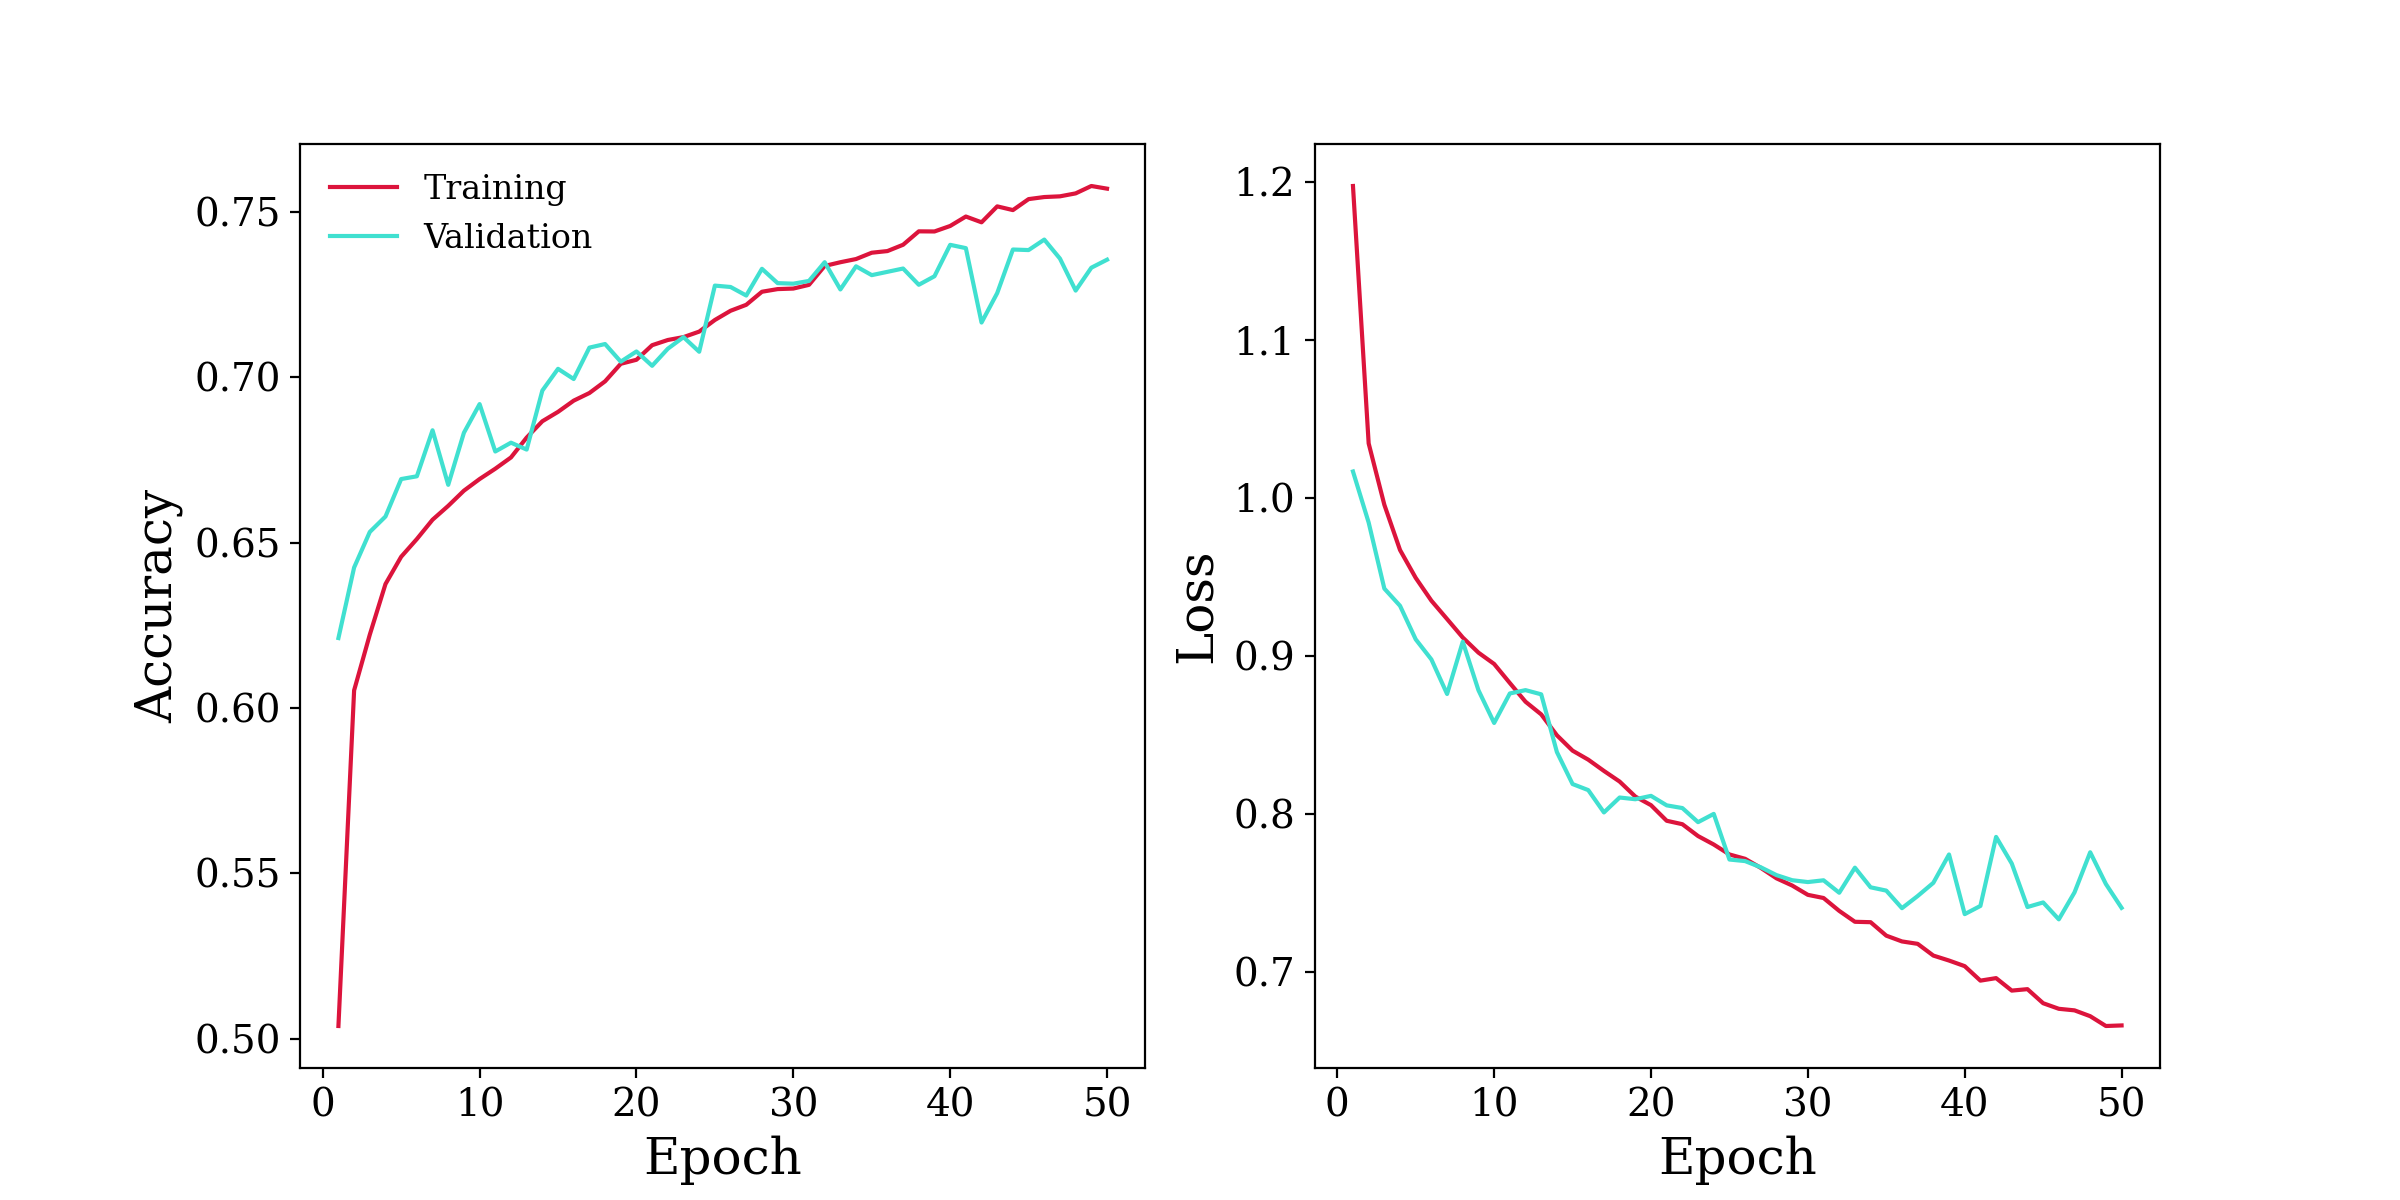

The final accuracy was 0.7571 and the final loss was 0.6659


In [7]:
loss_acc(history_1, 'img')

### 4.3 Evaluating Model (ROC & Confusion Matrix)

The ROC curve displays the True Positive Rate (TPR) against the False Positive Rate (FPR). True Positive (TP) is an image correctly classified as a positive by the model, in other words the model has correctly identifed a gluon image as a gluon image. False Positive (FP) is an image classified as belonging to a class when it actually doesn't. TPR and FPR are defined as

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \quad \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

where TN is True Negative and FN is False Negative.

In [8]:
#Take each image from the images_test array and predicts probability of belonging to each class
probabilities_img = model_1.predict(images_test)

375/375 [==============================] - 2s 4ms/step


The probabilites array will be of shape (12000, 5) because there are 12,000 testing images (and labels) and 5 labels available. To see how this works, take for example 'probabilities_img[0]'.

for i in range(len(probabilities_img[0])):
    print(f'Probability of prediciting a {particle_types[i]} is {probabilities_img[0][i] * 100}%')

The model thinks that images_test[0] is most likely from a top quark with a 99% chance. To see what the image actually is from, look at labels_test[0].

In [9]:
labels_test[0]

4

A label of 4 is the last type of particle e.g. a top quark, so the model has predicted correctly. Looking at 'probabilities_img[6]' and 'labels_test[6]':

In [10]:
for i in range(len(probabilities_img[6])):
    print(f'Probability of prediciting a {particle_types[i]} is {probabilities_img[6][i] * 100}%')

Probability of prediciting a Gluon is 2.688027173280716%
Probability of prediciting a Quark is 7.964159548282623%
Probability of prediciting a W is 84.17980670928955%
Probability of prediciting a Z is 2.846738323569298%
Probability of prediciting a T is 2.321264147758484%


In [11]:
labels_test[6]

4

The image is also a top quark, but the model only predicts it to be one with an 8% chance. It most likely thinks it is a W boson, indicating that the model is not very accurate.

Plotting the ROC curve will visualise how the model predicts false positives and negatives.

In [12]:
labels_test_binarised = label_binarize(labels_test, classes=range(5))

<IPython.core.display.Javascript object>


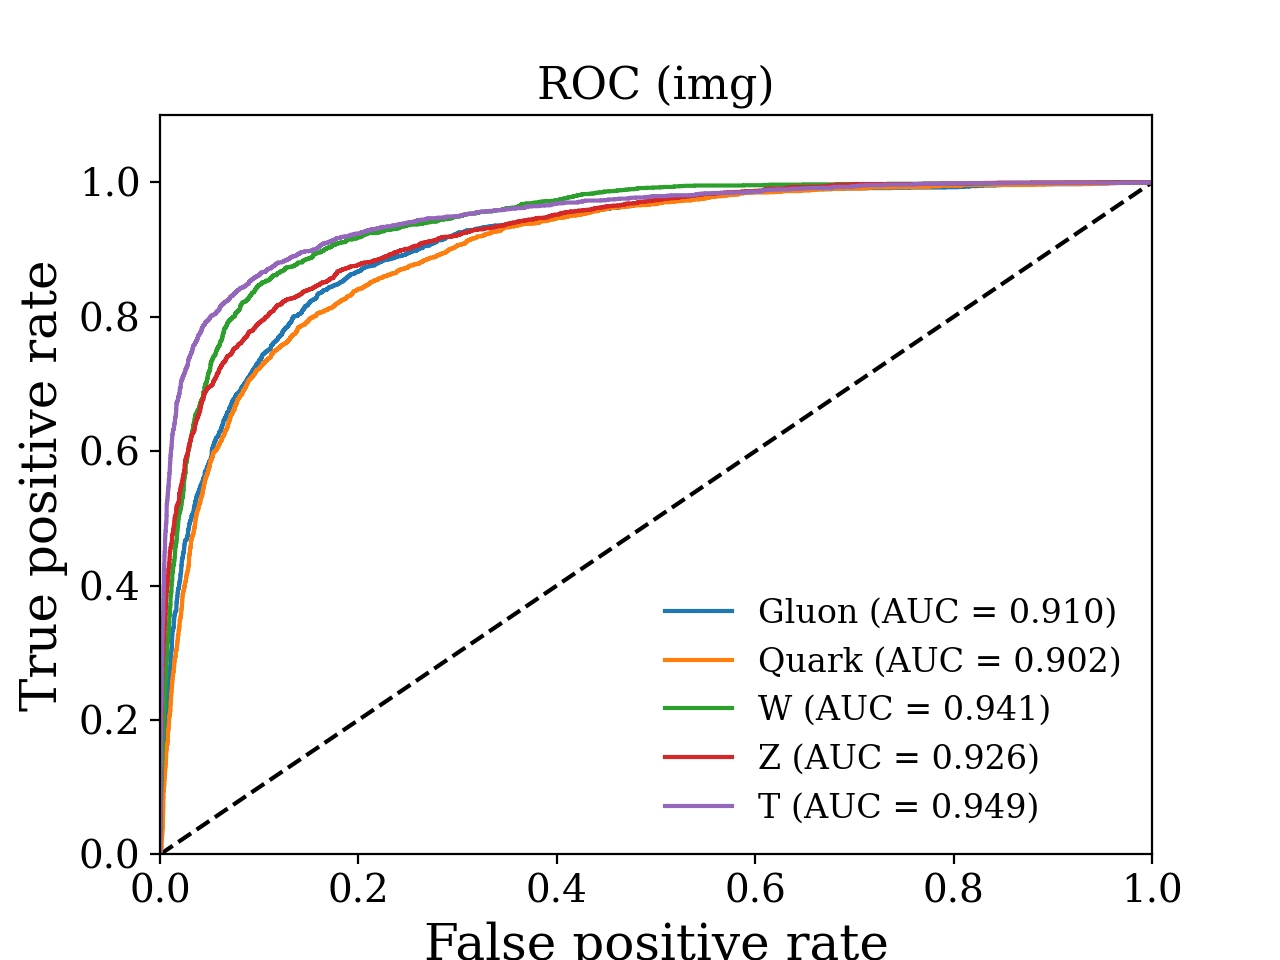

In [13]:
roc_img = ROC(probabilities_img, 'img')

The confusion matrix is a graphical representation of how the model correctly or incorrectly predicts each label.

Accuracy for Gluon: 67.81%
Accuracy for Quark: 68.29%
Accuracy for W: 76.25%
Accuracy for Z: 73.14%
Accuracy for T: 78.36%


<IPython.core.display.Javascript object>


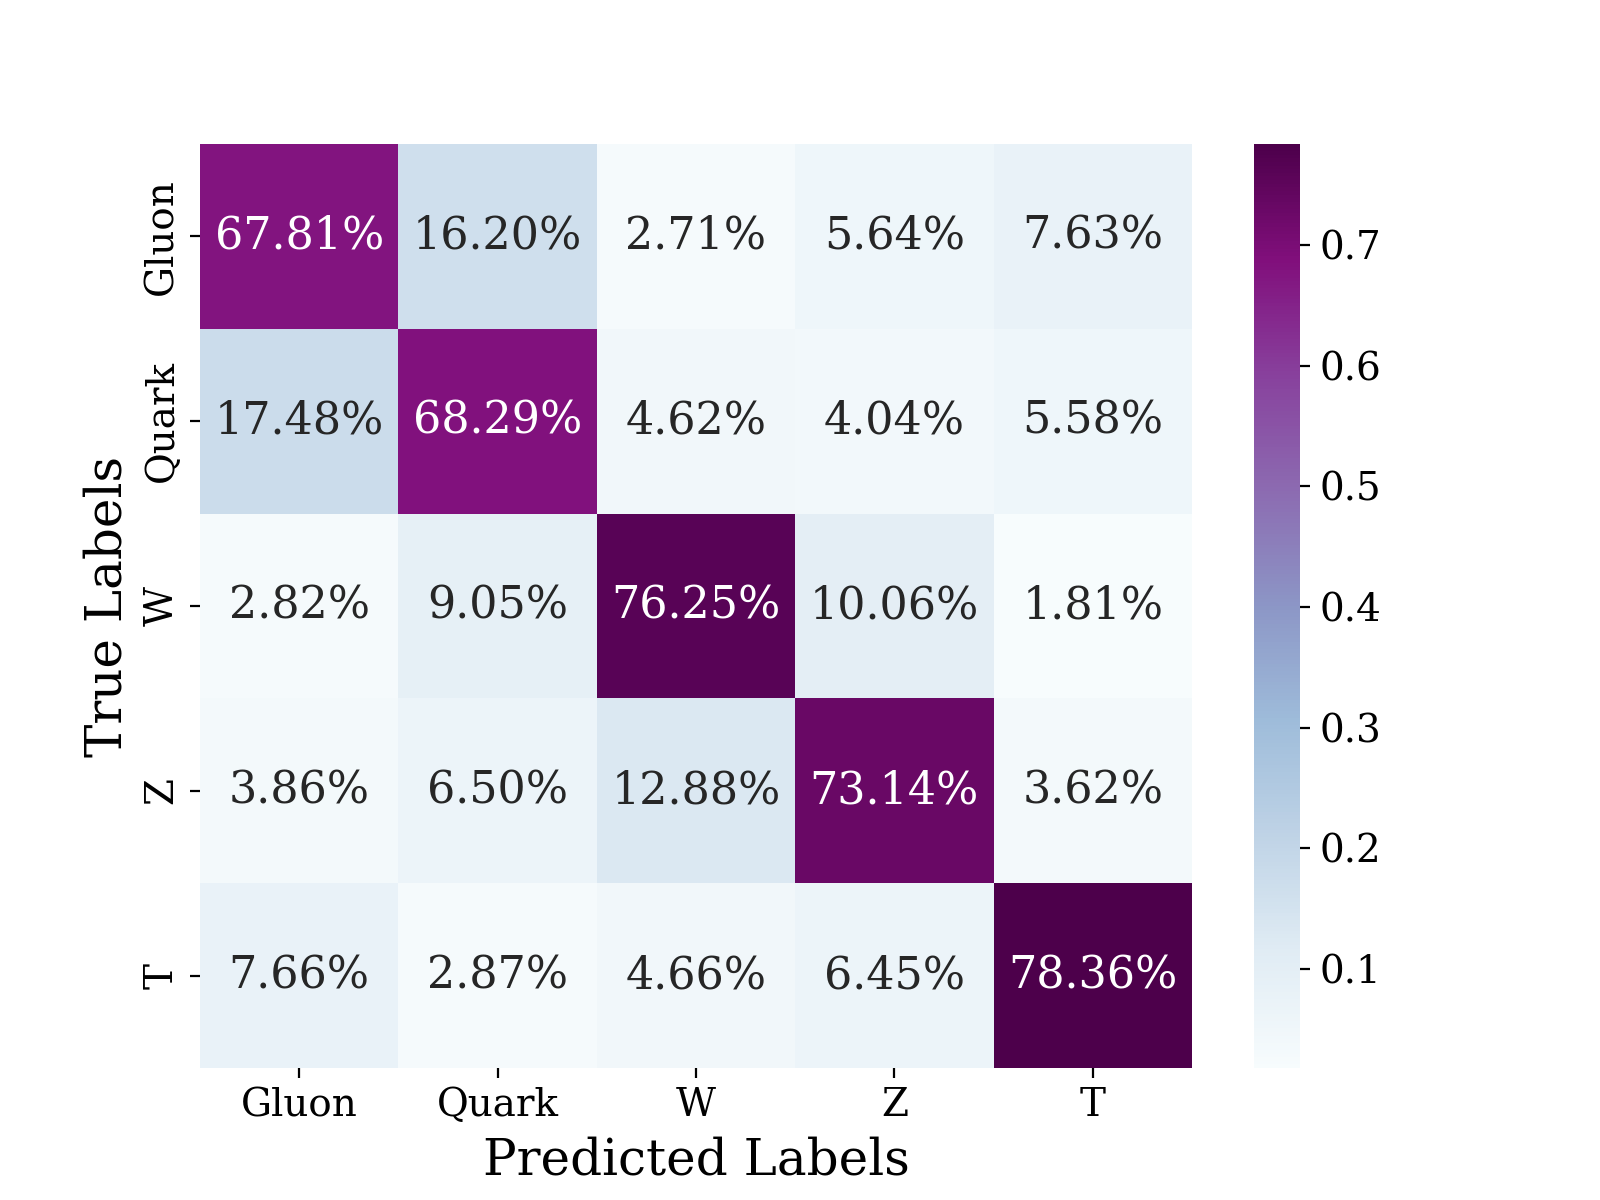

In [14]:
img_pred_labels, img_acc = conf(probabilities_img, 'img')

The main diagonal represent the true positives. The darker the shade the higher proportion of correctly identified images. The numbers along the main diagonal represent the proportion of correctly identified particls. For a highly accurate model, the main diagonals will be the darkest and all the other elements will be very light. For our model, the classes of events, going from easiest to hardest to seperate are:

1. W bosons
2. Top quarks
3. Z bosons
4. (light) Quarks
5. Gluons

We can also view the report of the model, which shows the precision, recall and f1-score for each classification.

The precision is given by 

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

and measures the correct classifications against all classifications.

The recall is given by 

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

and measures the correct classification of a class.

The F1-score is an overall measure of how good the model is at correctly classifying classes, and is given by

$$\text{F1} = 2~ \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [15]:
report_img = classification_report(labels_test, img_pred_labels, target_names = particle_types)
print(report_img)

              precision    recall  f1-score   support

       Gluon       0.68      0.68      0.68      2358
       Quark       0.67      0.68      0.67      2403
           W       0.75      0.76      0.76      2375
           Z       0.74      0.73      0.74      2461
           T       0.81      0.78      0.80      2403

    accuracy                           0.73     12000
   macro avg       0.73      0.73      0.73     12000
weighted avg       0.73      0.73      0.73     12000



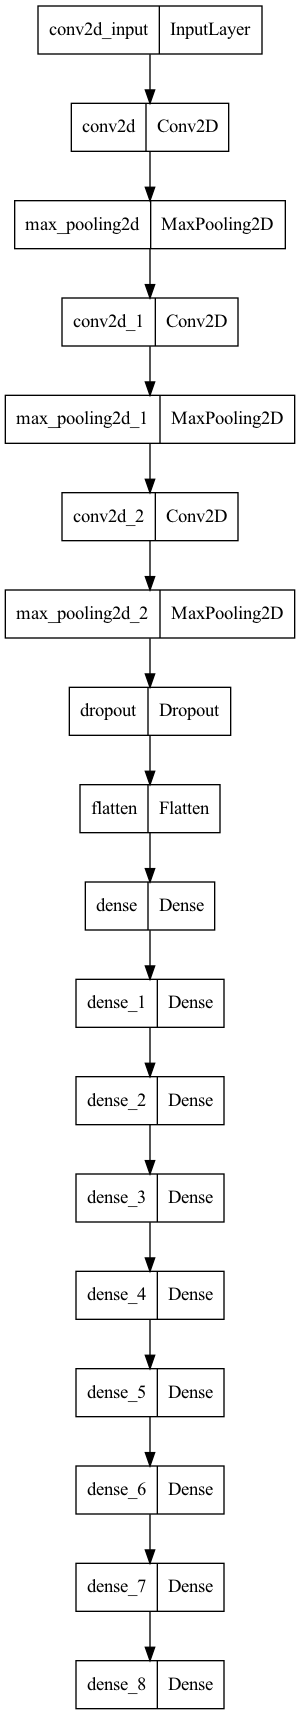

In [16]:
plot_model(model_1)

### 4.4 Visualising Convolutional Models

63/63 [==============================] - 0s 1ms/step


<IPython.core.display.Javascript object>


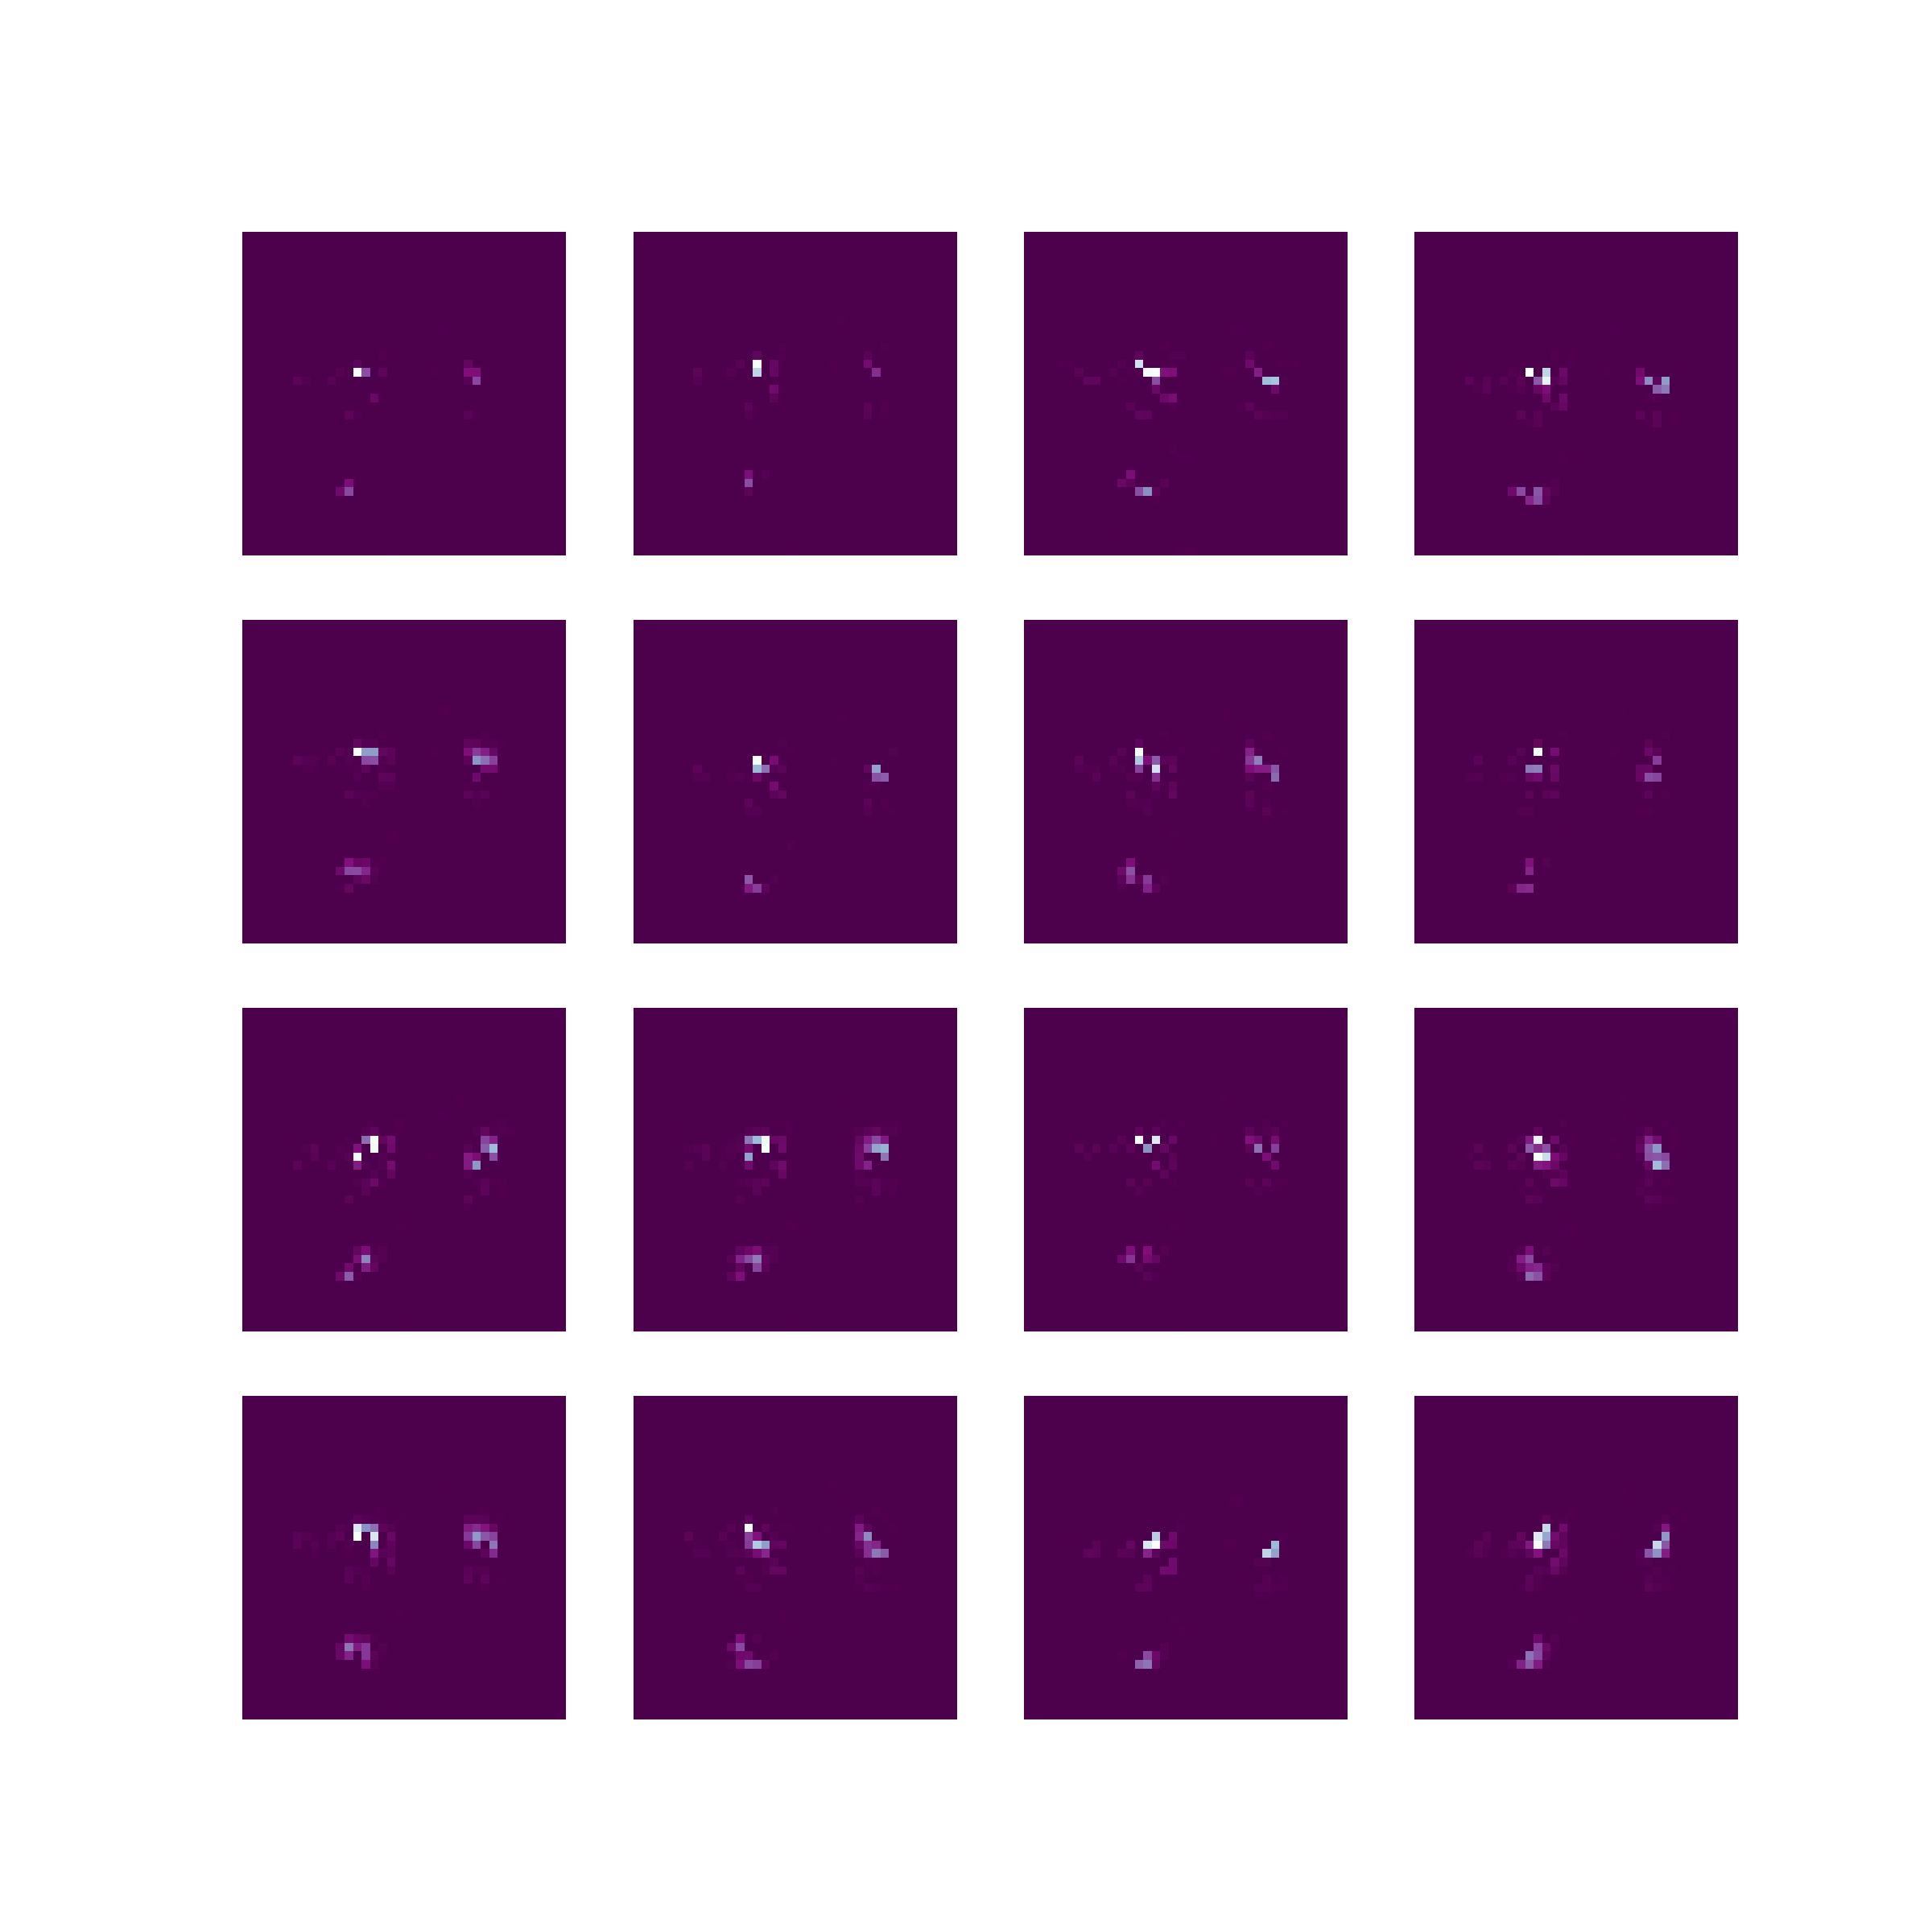

<IPython.core.display.Javascript object>


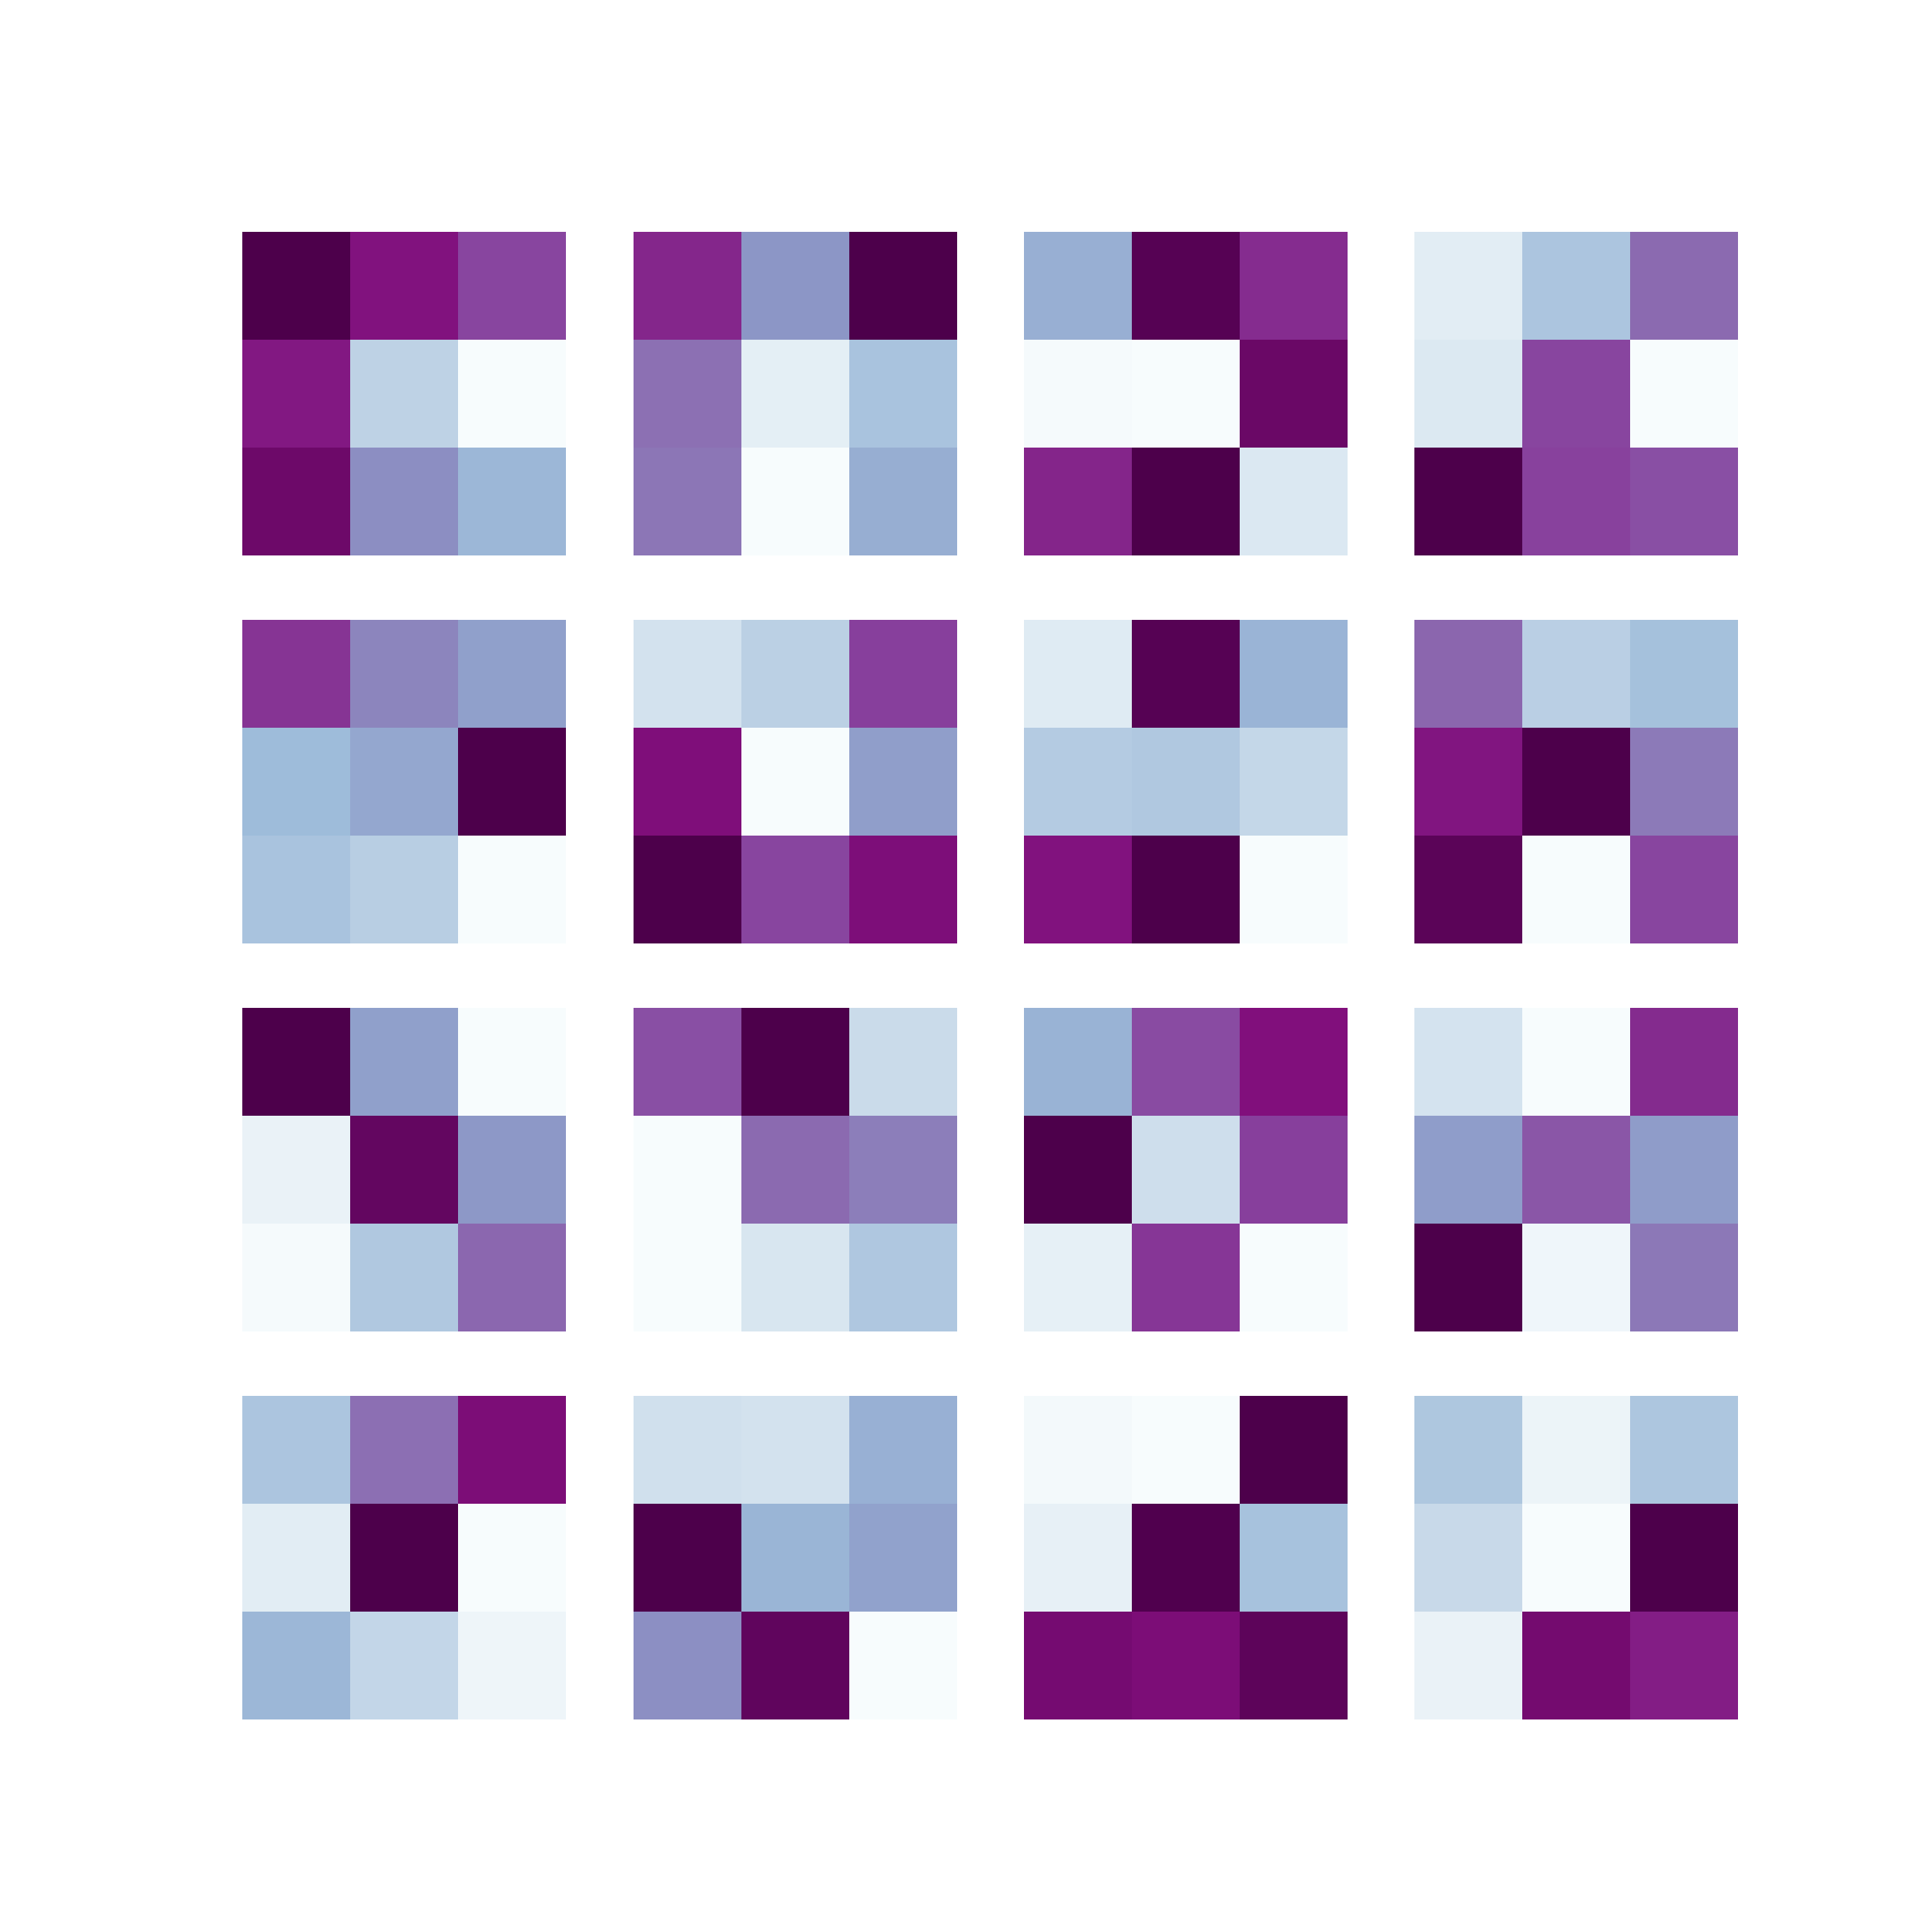

In [17]:
#Taking a sample image
convimg = crop_images_center(top_img_8)

convimg = convimg.reshape(-1, 40, 40, 1)

#Just a very simple convolutional layer, with 16 3x3 filters
modelconv = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(40, 40, 1))
])

# Use the model to get the feature maps
filtered_img = modelconv.predict(convimg)

# Define the colormap normalization
norm = LogNorm(vmin=0.01, vmax=1e3)

#Plot the 16 feature maps in 4x4 subplots
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(filtered_img[0, :, :, i], cmap='BuPu_r')
    plt.axis('off')
plt.show()
plt.savefig('Kernals.pdf', dpi =1000)

#Plot the 16 convolutional filters
filters, biases = modelconv.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

plt.figure(figsize=(12, 12))
for i in range(16):
    f = filters[:, :, 0, i] 
    plt.subplot(4, 4, i+1)
    plt.imshow(f, cmap='BuPu_r')
    plt.axis('off')
plt.show()
plt.savefig('Filter.pdf', dpi = 1000)

<IPython.core.display.Javascript object>


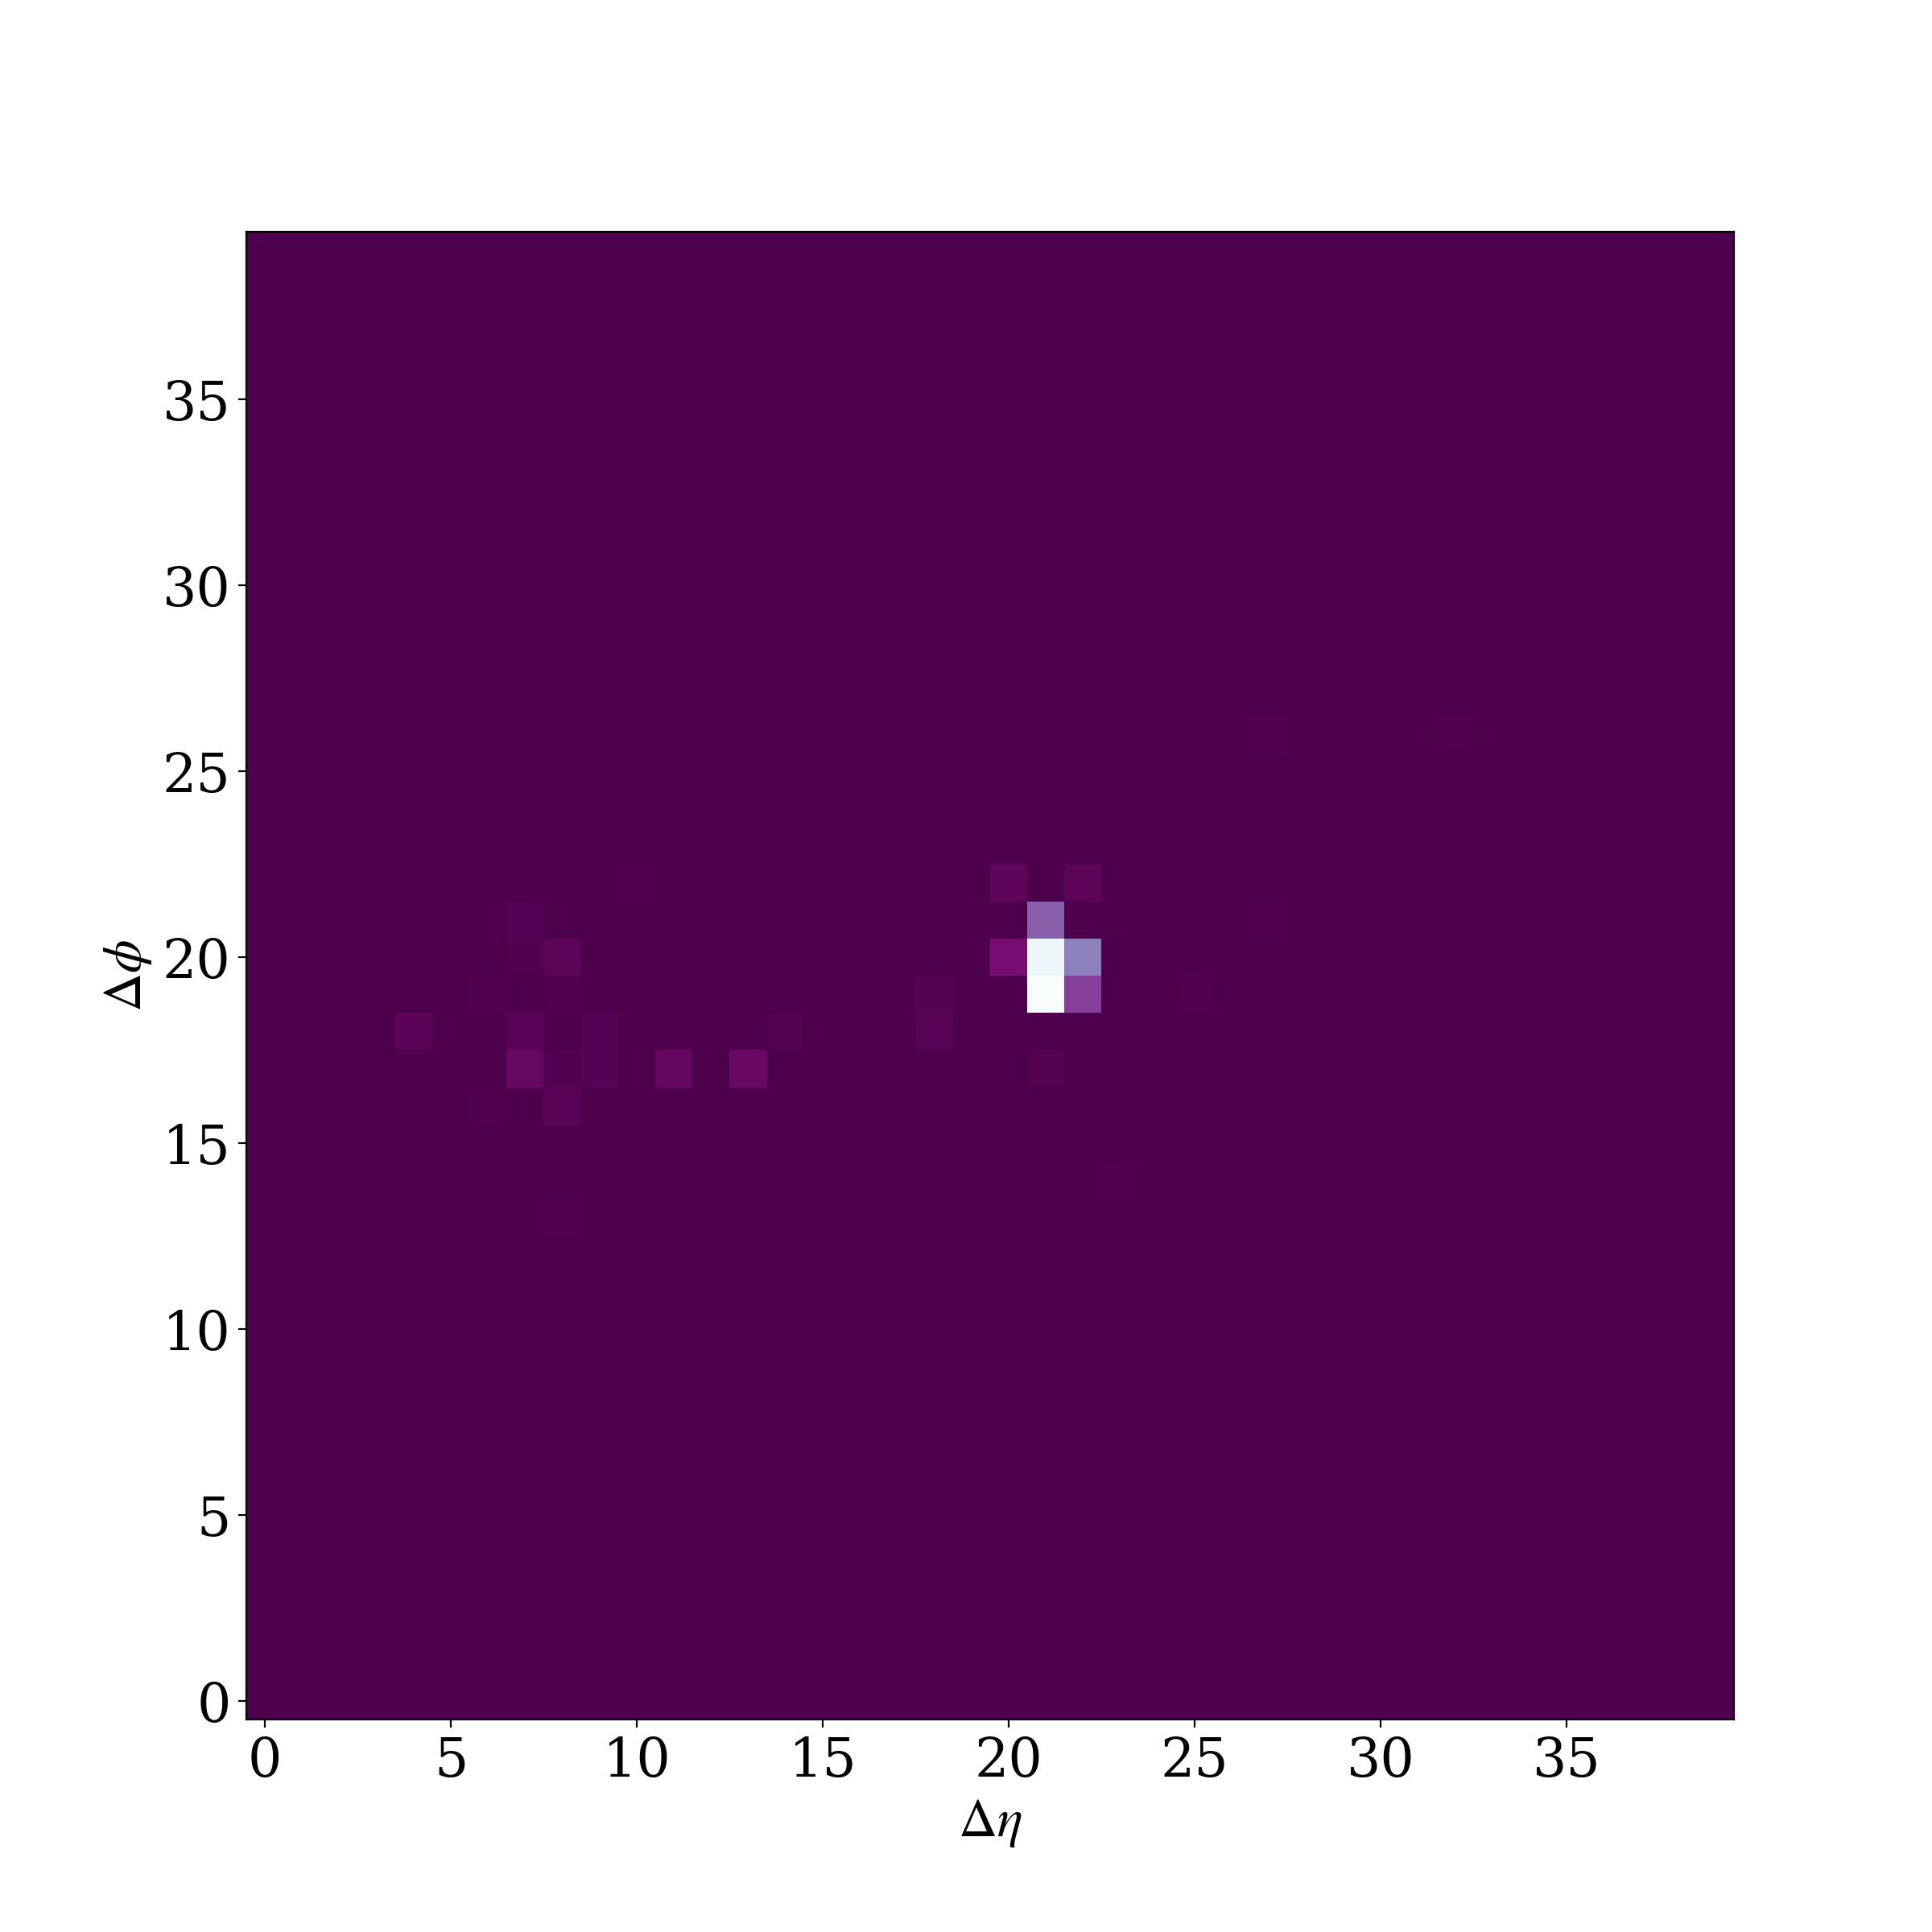

In [18]:
#Plot the sample image used
plt.figure(figsize=(12, 12)) 
plt.imshow(convimg[2000], origin = 'lower', cmap = 'BuPu_r')  
plt.xlabel(r'$\Delta\eta$', fontsize = 24)
plt.ylabel(r'$\Delta\phi$', fontsize = 24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()
plt.savefig('CNNmodel.pdf', dpi = 1000)

## 5 Task 2: Jet Features

### 5.1 The Jet Features

The files contain 53 jet features. These include:

| Feature      | Description |
| ----------- | ----------- |
| j_pt      | The transverse momentum of the jet   |
| j_eta      | The pseudorapidity of the jet  |
| j_mass     | The jet mass  |
| j_tau*   | A jet shape variable        |
| j_c*   | A jet shape variable        |
| j_multiplicity   | The number of particles in the jet      |
| j_zlogz | Splitting function |

In [19]:
features = ['j_pt', 'j_eta', 'j_mass', 'j_zlogz', 'j_multiplicity', 'j_tau3_b1', 'j_d2_b2', 'j_d2_a1_b2', 
    'j_n2_b2', 'j_tau32_b1_mmdt', 'j_c1_b1_mmdt', 'j_c2_b1_mmdt', 'j_n2_b1_mmdt', 'j_mass_trim', 
            'j_mass_mmdt', 'j_mass_sdb2']

In [20]:
def get_features(filename):
    '''Function to extract data from h5 file from the UCL HEP website
    input: 
    filename: string, file path
    
    returns:
    scaled arrays of features'''

    if not os.path.isfile(filename):
        if not os.path.isdir('data/train'):
            os.makedirs('data/train')
        urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/jetimage/' + filename, filename)

    with h5py.File(filename, 'r') as df:
        #Decode the labels for each column
        labels = [label.decode('utf-8') for label in df['jetFeatureNames'][:]]

        #Load the dataset into a DataFrame
        pJet = pd.DataFrame(np.array(df['jets']), columns=labels)

        #Initialize a dictionary to store scaled features
        scaled_features = {}

        for feature in features:
            feature_data = {}

            # Iterate over particle types
            for particle_type in ['g', 'q', 'w', 'z', 't']:
                # Filter rows based on the particle type
                data_particle = pJet[pJet[f'j_{particle_type}'] > 0]

                # Extract and scale the feature for the current particle type
                if feature in data_particle.columns:
                    feature_values = data_particle[feature].values.reshape(-1, 1)
                    scaled_values = scaler.fit_transform(feature_values).flatten()
                    feature_data[particle_type] = scaled_values
                else:
                    feature_data[particle_type] = np.array([])

            # Store the scaled feature data
            scaled_features[feature] = feature_data

    return scaled_features

In [21]:
def create_scalar_model(feature_name):
    
    #The images will go through 3 conv layers
    image_input = Input(shape=(40, 40, 1), name = 'image_input')
    
    x_image = Conv2D(32, (3, 3), activation='relu')(image_input)
    
    x_image = MaxPooling2D((2, 2))(x_image)
    
    x_image = Conv2D(64, (3, 3), activation = 'relu')(x_image)
    
    x_image = MaxPooling2D((2, 2))(x_image)
    
    x_image = Conv2D(64, (3, 3), activation = 'relu')(x_image)
    
    x_image = MaxPooling2D((2, 2))(x_image)
    
    x_image = Dropout(0.25)(x_image)
    
    x_image = Flatten()(x_image)

    #The input for the jet feature
    scalar_input = Input(shape = (1,), name = f'jet_{feature_name}_input')
    
    x_scalar = Dense(128, activation = 'relu')(scalar_input)
    
    x_scalar = Dense(64, activation = 'relu')(x_scalar)
    
    #Concatenating image and feature outputs
    
    concatenated = concatenate([x_image, x_scalar])
    
    x_combined = Dense(256, activation = 'relu')(concatenated)
    
    x_combined = Dense(128, activation = 'sigmoid')(x_combined)
    
    x_combined = Dense(64, activation = 'relu')(x_combined)
    
    x_combined = Dense(5, activation = 'softmax')(x_combined)
    
    model = Model(inputs = [image_input, scalar_input], outputs = x_combined)
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    return model

#One hot encoding the labels, essentially turning them into arrays of length 5 where e.g. [0,0,1,0,0] is W.
labels_train_onehot = to_categorical(labels_train, num_classes=5)
labels_val_onehot = to_categorical(labels_val, num_classes=5)
labels_test_onehot = to_categorical(labels_test, num_classes=5)

In [22]:
particle_types_f = ['g', 'q', 'w', 'z', 't'] 

#Dictionary to hold concatenated arrays for each feature and particle
concatenated_features = {feature: {ptype: [] for ptype in particle_types_f} for feature in features}

#Loop over files and features
for file_name in file_names:
    scaled_data = get_features(file_name)
    for feature in features:
        for ptype in particle_types_f:
            concatenated_features[feature][ptype].append(scaled_data[feature][ptype])

# Convert lists into array
for feature in concatenated_features:
    for ptype in concatenated_features[feature]:
        concatenated_features[feature][ptype] = np.concatenate(concatenated_features[feature][ptype])

### 5.2 Transverse momentum

In [23]:
pt = np.concatenate([concatenated_features['j_pt']['g'], concatenated_features['j_pt']['q'],
                    concatenated_features['j_pt']['w'], concatenated_features['j_pt']['z'],
                    concatenated_features['j_pt']['t']])

In [24]:
pt_train, pt_temp = train_test_split(pt, test_size=0.3, random_state=69)
pt_val, pt_test = train_test_split(pt_temp, test_size=0.5, random_state=69)

In [25]:
model_pt = create_scalar_model('pt')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 38, 38, 32)           320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 19, 19, 32)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 17, 17, 64)           18496     ['max_pooling2d_3[0][0]'] 

In [26]:
history_pt = model_pt.fit([images_train, pt_train], labels_train_onehot, epochs=Nepochs,
                    validation_data=([images_val, pt_val], labels_val_onehot), verbose=1)

Epoch 1/50
1750/1750 [==============================] - 23s 13ms/step - loss: 1.0650 - accuracy: 0.5828 - val_loss: 0.9256 - val_accuracy: 0.6532
Epoch 2/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.9392 - accuracy: 0.6418 - val_loss: 0.9090 - val_accuracy: 0.6562
Epoch 3/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.8907 - accuracy: 0.6639 - val_loss: 0.8420 - val_accuracy: 0.6885
Epoch 4/50
1750/1750 [==============================] - 24s 13ms/step - loss: 0.8576 - accuracy: 0.6774 - val_loss: 0.8200 - val_accuracy: 0.6927
Epoch 5/50
1750/1750 [==============================] - 24s 14ms/step - loss: 0.8345 - accuracy: 0.6862 - val_loss: 0.8202 - val_accuracy: 0.6957
Epoch 6/50
1750/1750 [==============================] - 24s 14ms/step - loss: 0.8172 - accuracy: 0.6941 - val_loss: 0.8090 - val_accuracy: 0.7035
Epoch 7/50
1750/1750 [==============================] - 24s 14ms/step - loss: 0.7977 - accuracy: 0.7013 - val_loss: 0.7566 -

<IPython.core.display.Javascript object>


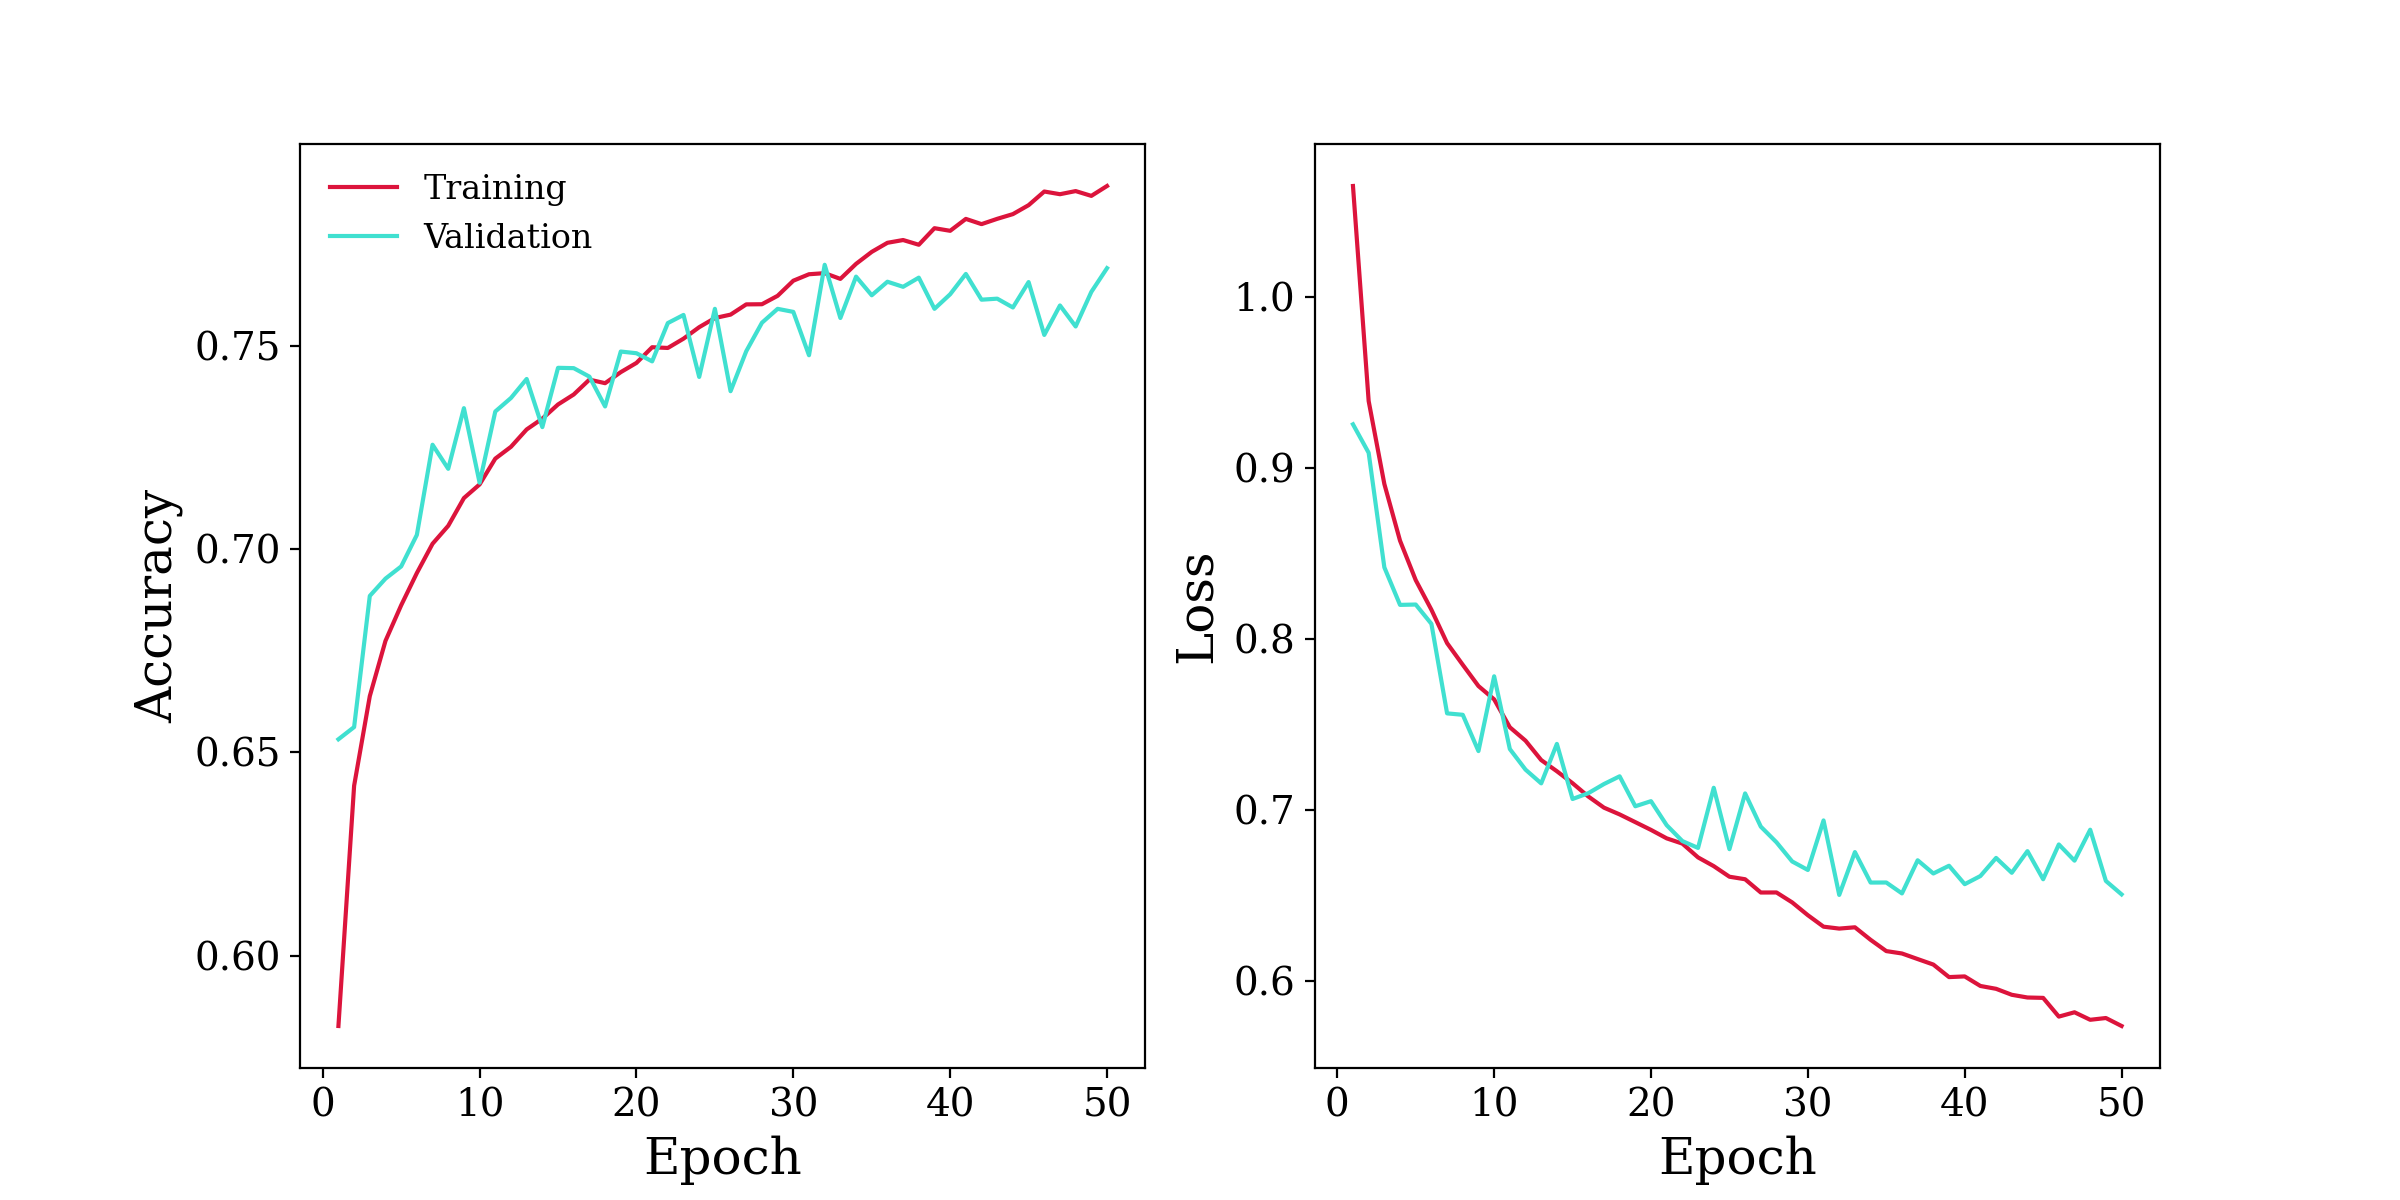

The final accuracy was 0.7893 and the final loss was 0.5738


In [27]:
loss_acc(history_pt, 'pt')

In [28]:
probabilities_pt = model_pt.predict([images_test, pt_test])

375/375 [==============================] - 2s 5ms/step


<IPython.core.display.Javascript object>


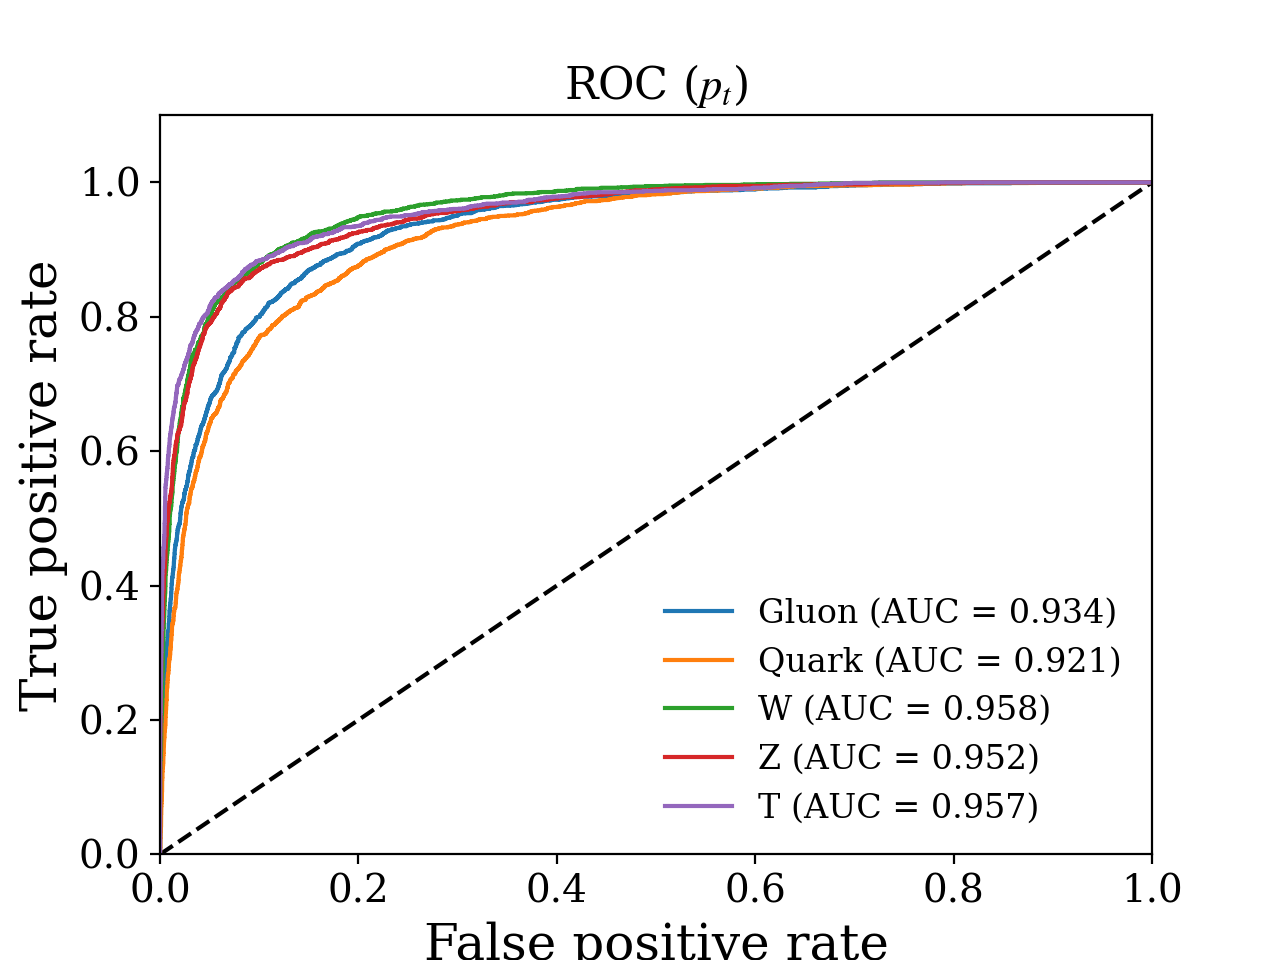

In [29]:
roc_pt = ROC(probabilities_pt, '$p_t$')

Accuracy for Gluon: 73.49%
Accuracy for Quark: 72.24%
Accuracy for W: 79.45%
Accuracy for Z: 78.99%
Accuracy for T: 78.61%


<IPython.core.display.Javascript object>


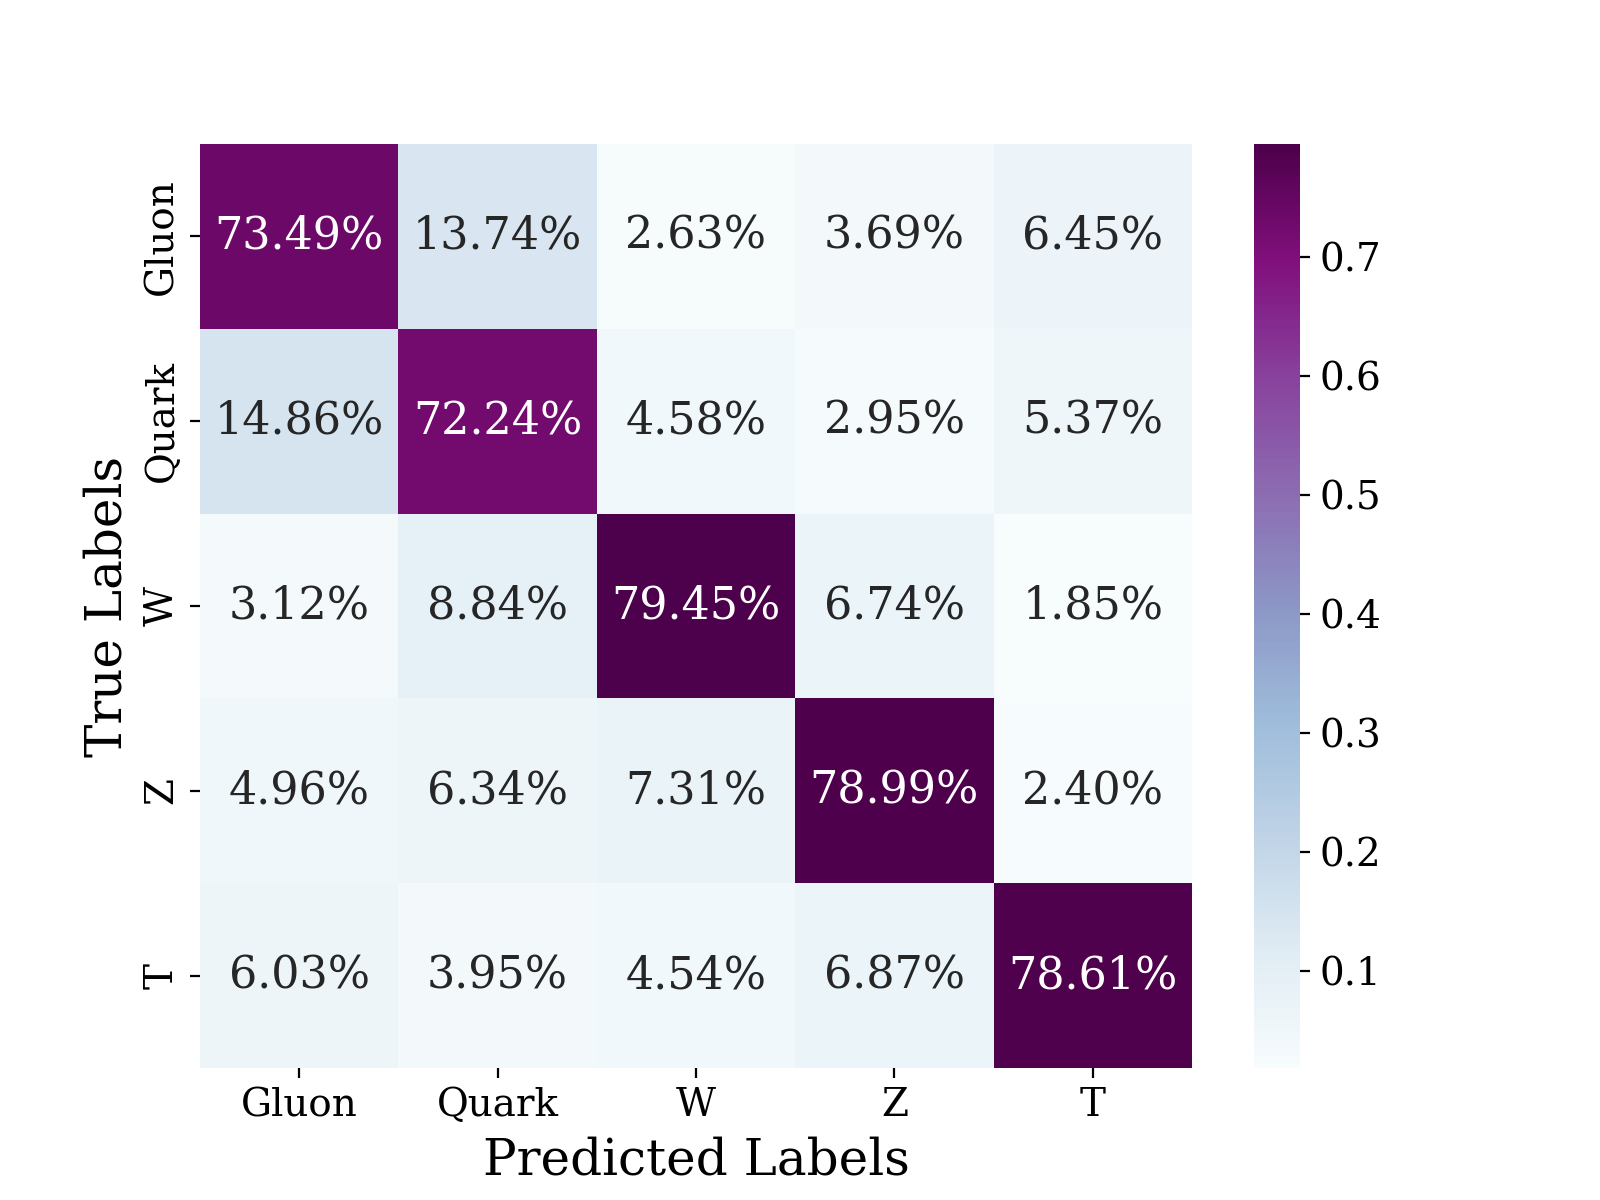

In [30]:
pt_pred_labels, pt_acc = conf(probabilities_pt, '$p_t$')

In [31]:
report_pt = classification_report(labels_test, pt_pred_labels, target_names = particle_types)
print(report_pt)

              precision    recall  f1-score   support

       Gluon       0.71      0.73      0.72      2358
       Quark       0.69      0.72      0.71      2403
           W       0.80      0.79      0.80      2375
           Z       0.80      0.79      0.80      2461
           T       0.83      0.79      0.81      2403

    accuracy                           0.77     12000
   macro avg       0.77      0.77      0.77     12000
weighted avg       0.77      0.77      0.77     12000



### 5.3 Pseudorapidity

In [32]:
eta = np.concatenate([concatenated_features['j_eta']['g'], concatenated_features['j_eta']['q'],
                    concatenated_features['j_eta']['w'], concatenated_features['j_eta']['z'],
                    concatenated_features['j_eta']['t']])

In [33]:
eta_train, eta_temp = train_test_split(eta, test_size=0.3, random_state=69)
eta_val, eta_test = train_test_split(eta_temp, test_size=0.5, random_state=69)

In [34]:
model_eta = create_scalar_model('eta')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 38, 38, 32)           320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 19, 19, 32)           0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 17, 17, 64)           18496     ['max_pooling2d_6[0][0]'

In [35]:
history_eta = model_eta.fit([images_train, eta_train], labels_train_onehot, epochs = Nepochs,
                    validation_data = ([images_val, eta_val], labels_val_onehot), verbose = 1)

Epoch 1/50
1750/1750 [==============================] - 23s 13ms/step - loss: 1.0897 - accuracy: 0.5723 - val_loss: 0.9754 - val_accuracy: 0.6309
Epoch 2/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.9927 - accuracy: 0.6199 - val_loss: 0.9719 - val_accuracy: 0.6316
Epoch 3/50
1750/1750 [==============================] - 24s 14ms/step - loss: 0.9554 - accuracy: 0.6379 - val_loss: 0.9181 - val_accuracy: 0.6549
Epoch 4/50
1750/1750 [==============================] - 24s 14ms/step - loss: 0.9252 - accuracy: 0.6517 - val_loss: 0.8799 - val_accuracy: 0.6758
Epoch 5/50
1750/1750 [==============================] - 25s 14ms/step - loss: 0.9056 - accuracy: 0.6589 - val_loss: 0.8812 - val_accuracy: 0.6774
Epoch 6/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.8908 - accuracy: 0.6666 - val_loss: 0.8684 - val_accuracy: 0.6793
Epoch 7/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.8763 - accuracy: 0.6699 - val_loss: 0.8702 -

<IPython.core.display.Javascript object>


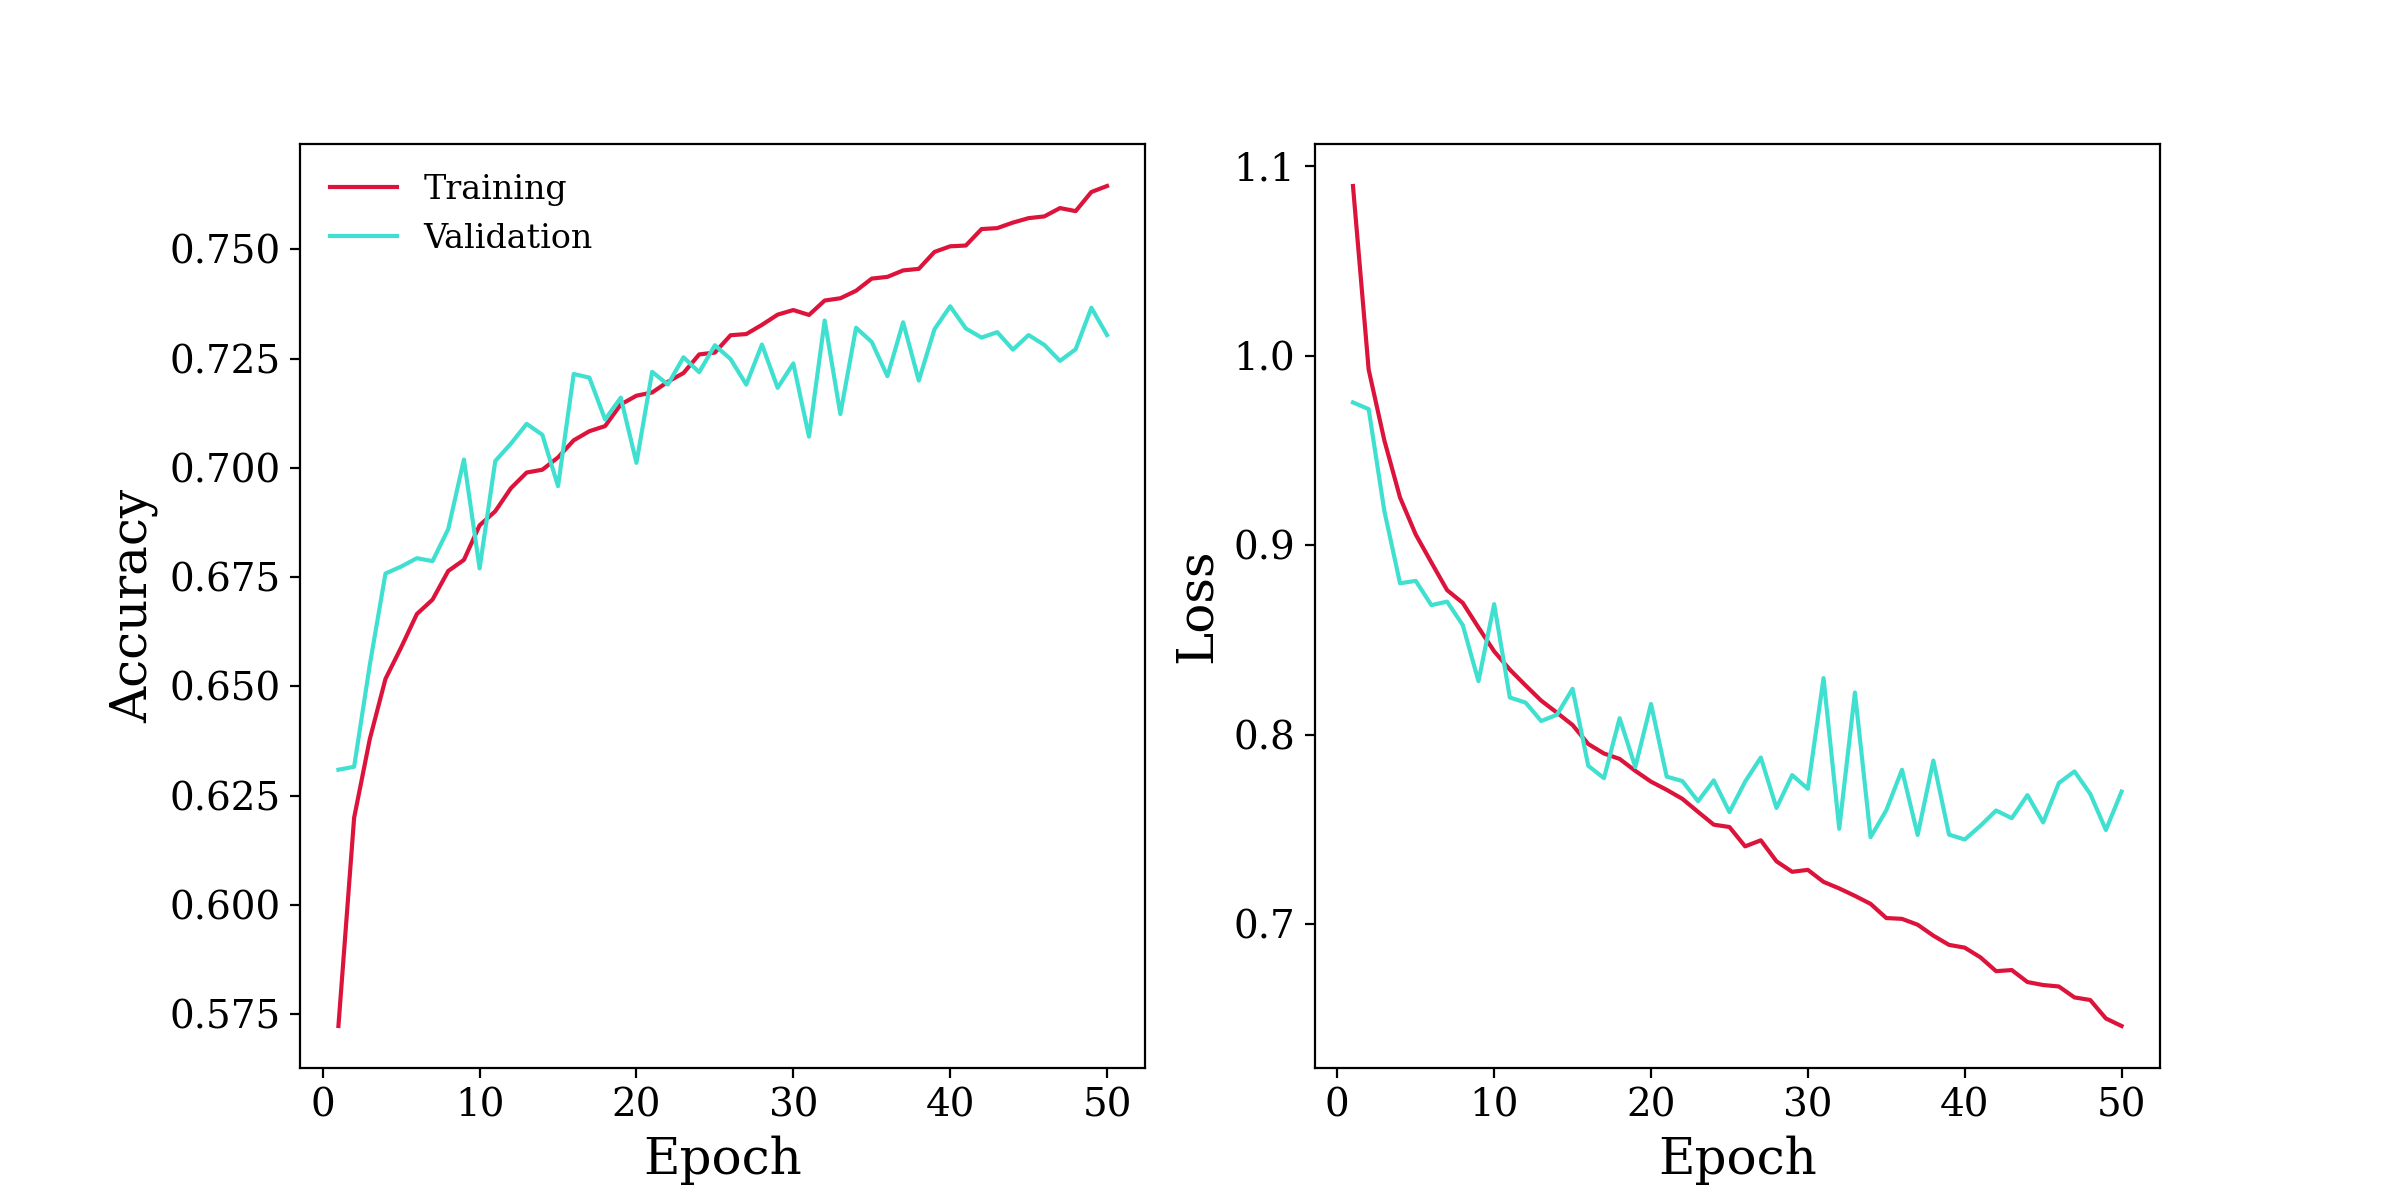

The final accuracy was 0.7645 and the final loss was 0.6461


In [36]:
loss_acc(history_eta, 'eta')

375/375 [==============================] - 2s 4ms/step


<IPython.core.display.Javascript object>


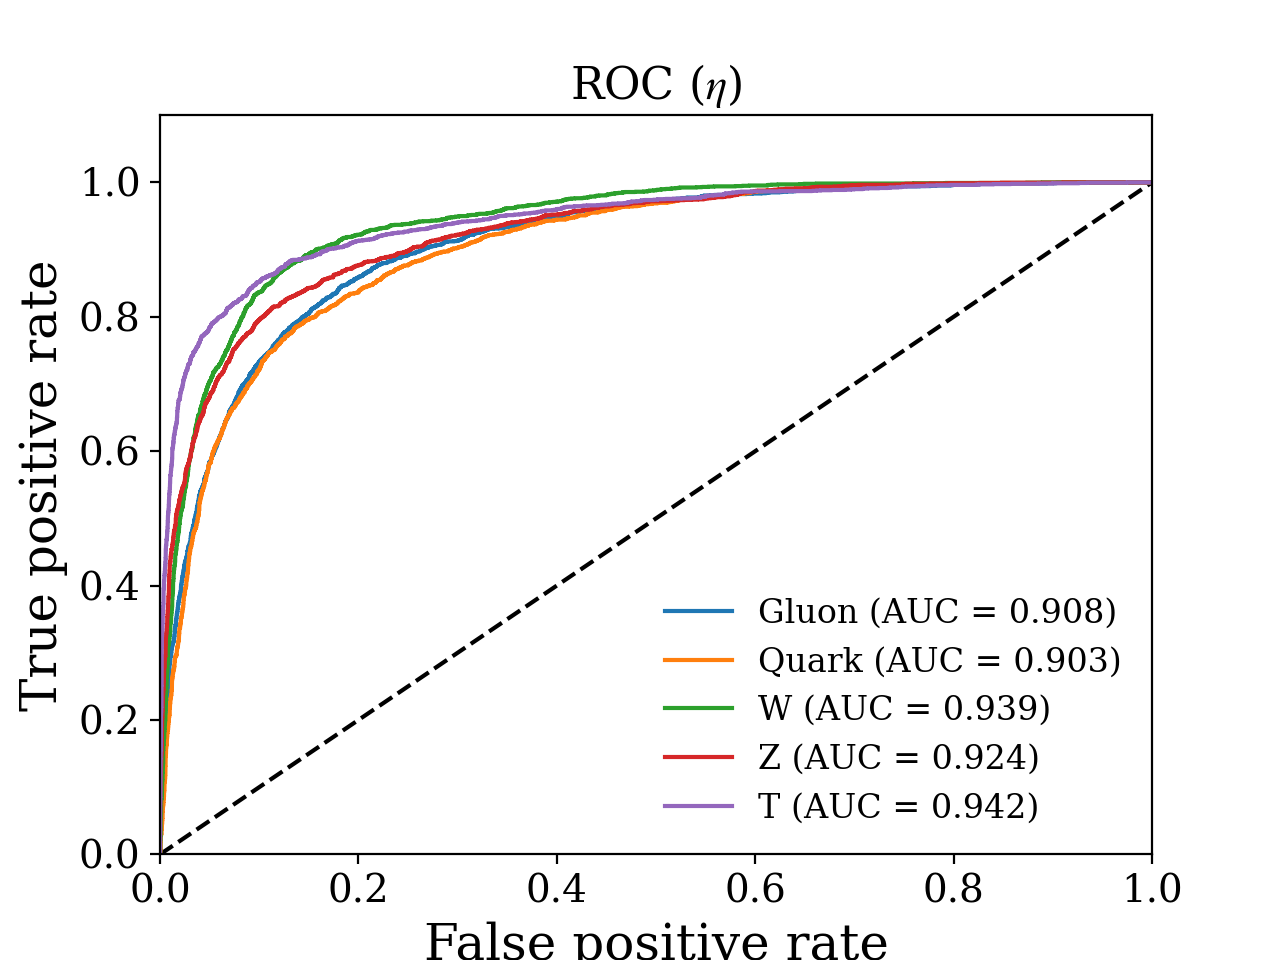

Accuracy for Gluon: 71.84%
Accuracy for Quark: 65.17%
Accuracy for W: 78.11%
Accuracy for Z: 70.82%
Accuracy for T: 75.03%


<IPython.core.display.Javascript object>


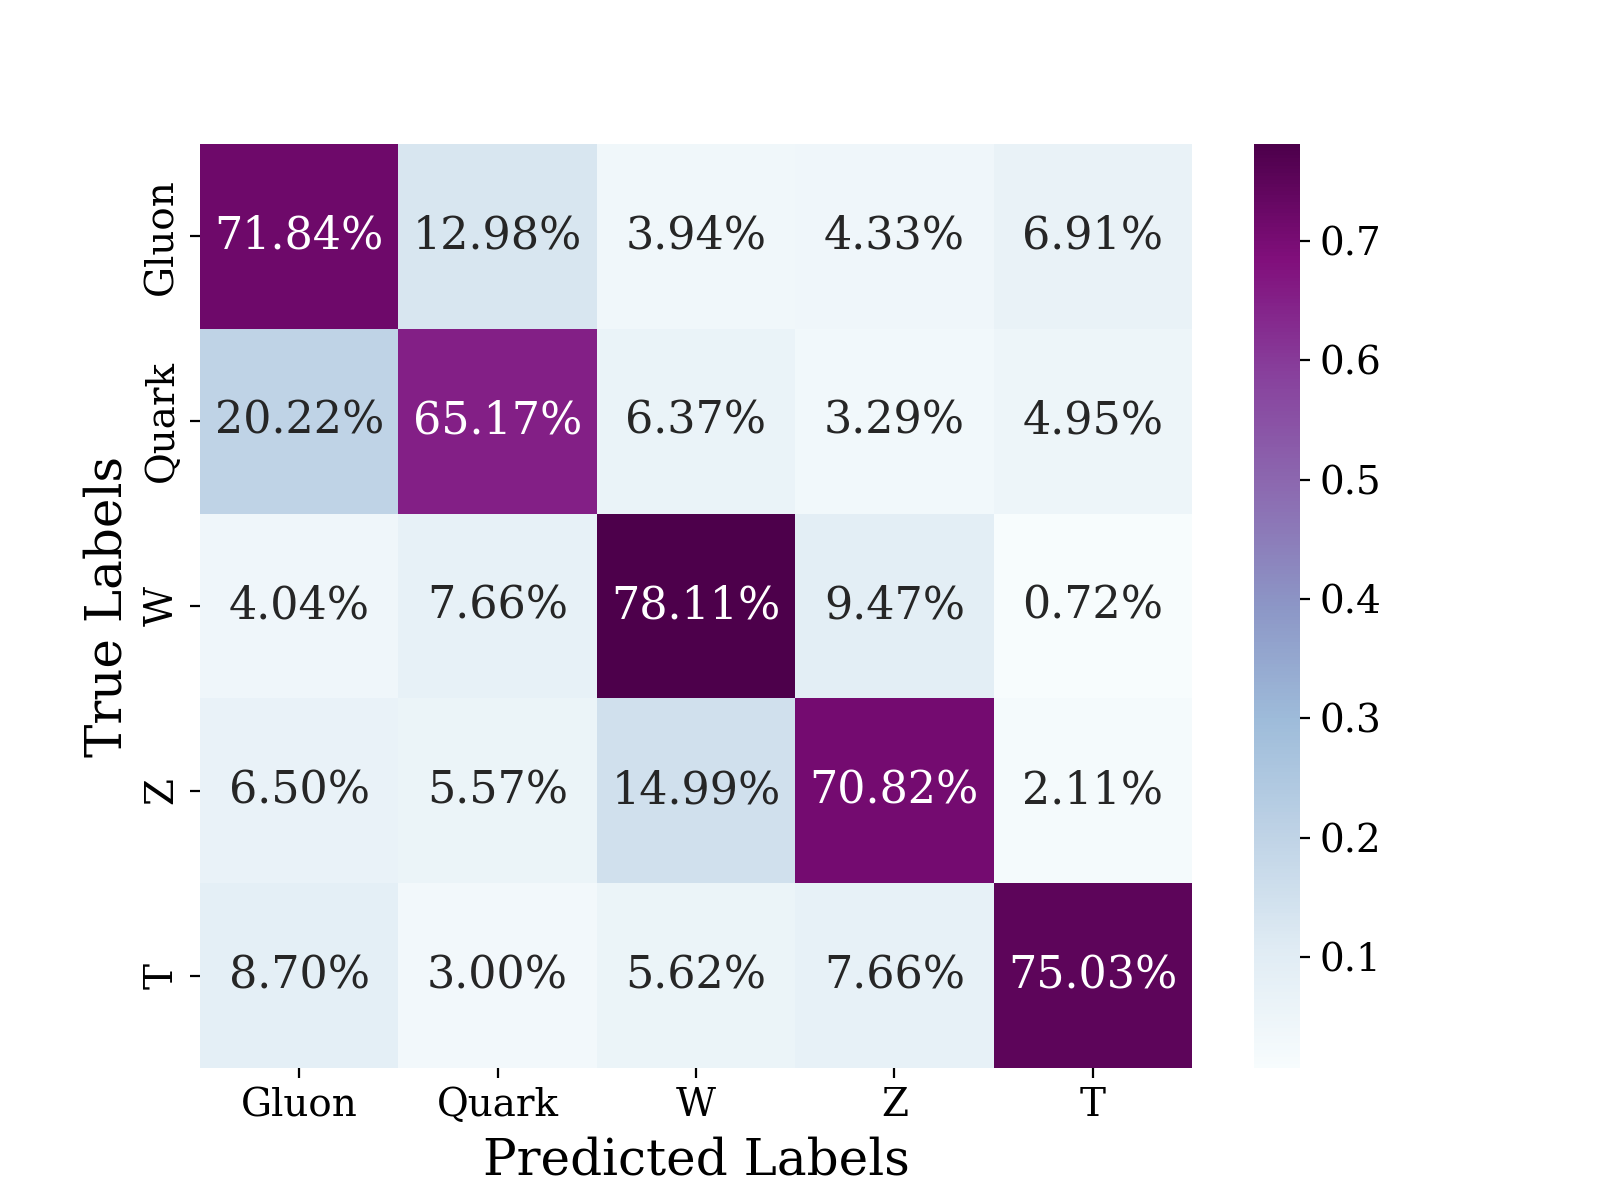

In [37]:
probabilities_eta = model_eta.predict([images_test, eta_test])
roc_eta = ROC(probabilities_eta, '$\eta$')
eta_pred_labels, eta_acc = conf(probabilities_eta, '$\eta$')

In [38]:
report_eta = classification_report(labels_test, eta_pred_labels, target_names = particle_types)
print(report_eta)

              precision    recall  f1-score   support

       Gluon       0.64      0.72      0.68      2358
       Quark       0.69      0.65      0.67      2403
           W       0.71      0.78      0.74      2375
           Z       0.75      0.71      0.73      2461
           T       0.84      0.75      0.79      2403

    accuracy                           0.72     12000
   macro avg       0.73      0.72      0.72     12000
weighted avg       0.73      0.72      0.72     12000



## 5.4 Jet Mass

In [39]:
mass = np.concatenate([concatenated_features['j_mass']['g'], concatenated_features['j_mass']['q'],
                    concatenated_features['j_mass']['w'], concatenated_features['j_mass']['z'],
                    concatenated_features['j_mass']['t']])

In [40]:
mass_train, mass_temp = train_test_split(mass, test_size=0.3, random_state=69)
mass_val, mass_test = train_test_split(mass_temp, test_size=0.5, random_state=69)

In [41]:
model_mass = create_scalar_model('mass')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 38, 38, 32)           320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 19, 19, 32)           0         ['conv2d_10[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 17, 17, 64)           18496     ['max_pooling2d_9[0][0]'

In [42]:
history_mass = model_mass.fit([images_train, mass_train], labels_train_onehot, epochs = Nepochs,
                    validation_data = ([images_val, mass_val], labels_val_onehot), verbose = 1)

Epoch 1/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.8062 - accuracy: 0.6577 - val_loss: 0.6953 - val_accuracy: 0.7120
Epoch 2/50
1750/1750 [==============================] - 22s 13ms/step - loss: 0.6474 - accuracy: 0.7281 - val_loss: 0.5847 - val_accuracy: 0.7585
Epoch 3/50
1750/1750 [==============================] - 22s 13ms/step - loss: 0.5845 - accuracy: 0.7569 - val_loss: 0.5141 - val_accuracy: 0.7912
Epoch 4/50
1750/1750 [==============================] - 22s 13ms/step - loss: 0.5534 - accuracy: 0.7705 - val_loss: 0.5099 - val_accuracy: 0.7918
Epoch 5/50
1750/1750 [==============================] - 22s 13ms/step - loss: 0.5282 - accuracy: 0.7824 - val_loss: 0.4937 - val_accuracy: 0.8022
Epoch 6/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.5056 - accuracy: 0.7921 - val_loss: 0.4950 - val_accuracy: 0.7939
Epoch 7/50
1750/1750 [==============================] - 23s 13ms/step - loss: 0.4949 - accuracy: 0.7969 - val_loss: 0.4393 -

KeyboardInterrupt: 

In [ ]:
loss_acc(history_mass, 'mass')

In [ ]:
probabilities_mass = model_mass.predict([images_test, mass_test])
roc_mass = ROC(probabilities_mass, 'mass')
mass_pred_labels, mass_acc = conf(probabilities_mass, 'mass')

In [ ]:
report_mass = classification_report(labels_test, mass_pred_labels, target_names = particle_types)
print(report_mass)

### 5.5 Jet Multiplicity

In [ ]:
mult = np.concatenate([concatenated_features['j_multiplicity']['g'], 
                       concatenated_features['j_multiplicity']['q'],
                       concatenated_features['j_multiplicity']['w'], 
                       concatenated_features['j_multiplicity']['z'],
                       concatenated_features['j_multiplicity']['t']])

In [ ]:
mult_train, mult_temp = train_test_split(mult, test_size=0.3, random_state=69)
mult_val, mult_test = train_test_split(mult_temp, test_size=0.5, random_state=69)

In [ ]:
model_mult = create_scalar_model('mult')

In [ ]:
history_mult = model_mult.fit([images_train, mult_train], labels_train_onehot, epochs = Nepochs,
                    validation_data = ([images_val, mult_val], labels_val_onehot), verbose = 1)

In [ ]:
loss_acc(history_mult, 'mult')

In [ ]:
probabilities_mult = model_mult.predict([images_test, mult_test])
roc_mult = ROC(probabilities_mult, 'mult')
mult_pred_labels, mult_acc = conf(probabilities_mult, 'mult')

In [ ]:
report_mult = classification_report(labels_test, mult_pred_labels, target_names = particle_types)
print(report_mult)

### 5.6 Jet Splitting

In [ ]:
z = np.concatenate([concatenated_features['j_zlogz']['g'], 
                       concatenated_features['j_zlogz']['q'],
                       concatenated_features['j_zlogz']['w'], 
                       concatenated_features['j_zlogz']['z'],
                       concatenated_features['j_zlogz']['t']])

In [ ]:
z_train, z_temp = train_test_split(z, test_size=0.3, random_state=69)
z_val, z_test = train_test_split(z_temp, test_size=0.5, random_state=69)

In [ ]:
model_z = create_scalar_model('zlogz')

In [ ]:
history_z = model_z.fit([images_train, z_train], labels_train_onehot, epochs = Nepochs,
                    validation_data = ([images_val, z_val], labels_val_onehot), verbose = 1)

In [ ]:
loss_acc(history_z, 'zlogz')

In [ ]:
probabilities_z = model_z.predict([images_test, z_test])
roc_z = ROC(probabilities_z, 'logz')
z_pred_labels, z_acc = conf(probabilities_z, 'zlogz')

In [ ]:
report_z = classification_report(labels_test, z_pred_labels, target_names = particle_types)
print(report_z)

### 5.7 Which Classes of Events are Easiest to Seperate?

Of these 5 features used in combination with the jet image, it comes to no suprise that jet mass leads to the most efficient classifier. This is because there is large differences in the masses of each type of particle, and this helps the model to learn what to classify an image as when also given the mass of the particle initaitng the jet.

In [ ]:
training_cats = ['Images', r'$p_t$', r'$\eta$', 'Mass', 'Mult.', '$z\log z$']

In [ ]:
group_names = training_cats
bar_labels = particle_types

# Random data generation for demonstration purposes
data = np.stack([img_acc, pt_acc, eta_acc, mass_acc, mult_acc, z_acc])

# Configurations for the bar positions
bar_width = 0.15
index = np.arange(6)
offsets = np.linspace(-0.2, 0.2, 5)

# Plotting the bars
fig, ax = plt.subplots(figsize=(14,8))
for i, offset in enumerate(offsets):
    ax.bar(index + offset, data[:, i], bar_width, label=bar_labels[i], alpha=0.7)

# Adding some presentation aspects
ax.set_xlabel('Feature', fontsize=20)
ax.set_ylabel('True positive rate', fontsize=20)
ax.set_xticks(index)
ax.set_xticklabels(group_names, fontsize=18)
ax.legend(loc='best', frameon= False, fontsize=16)

# Showing the plot
plt.tight_layout()
plt.savefig('Depend.pdf', dpi = 1000)
plt.show()


### 5.8 All Features

In [ ]:
#Now making a model using the jet image + the 5 features
image_input = Input(shape=(40, 40, 1), name='image_input')
x_image = Conv2D(32, (3, 3), activation='relu')(image_input)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Dropout(0.25)(x_image)
x_image = Flatten()(x_image)

#The features
pt_input = Input(shape=(1,), name='pt_input')
x_pt = Dense(128, activation = 'relu')(pt_input)
x_pt = Dense(64, activation = 'relu')(x_pt)

eta_input = Input(shape=(1,), name='eta_input')
x_eta = Dense(128, activation = 'relu')(eta_input)
x_eta = Dense(64, activation = 'relu')(x_eta)

mass_input = Input(shape=(1,), name='mass_input')
x_mass = Dense(128, activation = 'relu')(mass_input)
x_mass = Dense(64, activation = 'relu')(x_mass)

mult_input = Input(shape=(1,), name='mult_input')
x_mult = Dense(128, activation = 'relu')(mult_input)
x_mult = Dense(64, activation = 'relu')(x_mult)

z_input = Input(shape=(1,), name='zlogz_input')
x_z = Dense(128, activation = 'relu')(z_input)
x_z = Dense(64, activation = 'relu')(x_z)

concatenated = concatenate([x_image, x_pt, x_eta, x_mass, x_mult, x_z])

x_combined = Dense(256, activation='relu')(concatenated)
x_combined = Dense(128, activation='sigmoid')(x_combined)
x_combined = Dense(64, activation='relu')(x_combined)
x_combined = Dense(5, activation='softmax')(x_combined)

model_all = Model(inputs=[image_input, pt_input, eta_input, mass_input, mult_input, z_input], 
                  outputs=x_combined)

model_all.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_all.summary()


In [ ]:
plot_model(model_all)

In [ ]:
history_all = model_all.fit([images_train, eta_train, pt_train, mass_train, mult_train, z_train], 
                    labels_train_onehot, epochs = Nepochs,
                    validation_data = ([images_val, eta_val, pt_val, mass_val, mult_val, z_val], 
                    labels_val_onehot), verbose=1)

In [ ]:
loss_acc(history_all, 'all')

In [ ]:
probabilities_all = model_all.predict([images_test, eta_test, pt_test, mass_test, mult_test, z_test])
roc_all = ROC(probabilities_all, 'all')
all_pred_labels, all_acc = conf(probabilities_all, 'all')

The model still has a hard time differentiating between W and Z jet, while highly accurate at classifiying gluons, quarks and top. W and Z are most commonly misidentified as eachother.

In [ ]:
plt.figure()
plt.plot(np.arange(1, np.size(history_1.history['accuracy']) + 1, 1), 
         history_1.history['accuracy'], label = 'images')

plt.plot(np.arange(1, np.size(history_pt.history['accuracy']) + 1, 1), 
         history_pt.history['accuracy'], label = r'$p_T$')

plt.plot(np.arange(1, np.size(history_eta.history['accuracy']) + 1, 1), 
         history_eta.history['accuracy'],label = r'$\eta$')

plt.plot(np.arange(1, np.size(history_mass.history['accuracy']) + 1, 1), 
         history_mass.history['accuracy'], label = 'mass')

plt.plot(np.arange(1, np.size(history_mult.history['accuracy']) + 1, 1), 
         history_mult.history['accuracy'], label = 'mult.')

plt.plot(np.arange(1, np.size(history_z.history['accuracy']) + 1, 1), 
         history_z.history['accuracy'], label = r'$z\log z$')

plt.plot(np.arange(1, np.size(history_all.history['accuracy']) + 1, 1), 
         history_all.history['accuracy'], label = 'all')

plt.ylabel('Training accuracy')
plt.xlabel('Epoch')
plt.legend(frameon = False)

plt.figure()
plt.plot(np.arange(1, np.size(history_1.history['loss']) + 1, 1), 
         history_1.history['loss'], label = 'images')

plt.plot(np.arange(1, np.size(history_pt.history['loss']) + 1, 1), 
         history_pt.history['loss'], label = '$p_T$')

plt.plot(np.arange(1, np.size(history_eta.history['loss']) + 1, 1), 
         history_eta.history['loss'],label = '$\eta$')

plt.plot(np.arange(1, np.size(history_mass.history['loss']) + 1, 1), 
         history_mass.history['loss'], label = 'mass')

plt.plot(np.arange(1, np.size(history_mult.history['loss']) + 1, 1), 
         history_mult.history['loss'], label = 'mult.')

plt.plot(np.arange(1, np.size(history_z.history['loss']) + 1, 1), 
         history_z.history['loss'], label = '$z\log z$')

plt.plot(np.arange(1, np.size(history_all.history['loss']) + 1, 1), 
         history_all.history['loss'], label = 'all')

plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.legend(loc = 'best', frameon = False)

### 5.9 Additional Features

In [ ]:
#Incorportaing some additional features with no straigtfoward physical descriptions

tau3_b1 = np.concatenate([concatenated_features['j_tau3_b1']['g'], concatenated_features['j_tau3_b1']['q'],
                    concatenated_features['j_tau3_b1']['w'], concatenated_features['j_tau3_b1']['z'],
                    concatenated_features['j_tau3_b1']['t']])

d2_b2 = np.concatenate([concatenated_features['j_d2_b2']['g'], concatenated_features['j_d2_b2']['q'],
                    concatenated_features['j_d2_b2']['w'], concatenated_features['j_d2_b2']['z'],
                    concatenated_features['j_d2_b2']['t']])

d2_a1_b2 = np.concatenate([concatenated_features['j_d2_a1_b2']['g'], concatenated_features['j_d2_a1_b2']['q'],
                    concatenated_features['j_d2_a1_b2']['w'], concatenated_features['j_d2_a1_b2']['z'],
                    concatenated_features['j_d2_a1_b2']['t']])

n2_b2 = np.concatenate([concatenated_features['j_n2_b2']['g'], concatenated_features['j_n2_b2']['q'],
                    concatenated_features['j_n2_b2']['w'], concatenated_features['j_n2_b2']['z'],
                    concatenated_features['j_n2_b2']['t']])

n2_b1 = np.concatenate([concatenated_features['j_n2_b1_mmdt']['g'], concatenated_features['j_n2_b1_mmdt']['q'],
                    concatenated_features['j_n2_b1_mmdt']['w'], concatenated_features['j_n2_b1_mmdt']['z'],
                    concatenated_features['j_n2_b1_mmdt']['t']])

tau32_b1 = np.concatenate([concatenated_features['j_tau32_b1_mmdt']['g'], 
                concatenated_features['j_tau32_b1_mmdt']['q'], concatenated_features['j_tau32_b1_mmdt']['w'], 
                concatenated_features['j_tau32_b1_mmdt']['z'], concatenated_features['j_tau32_b1_mmdt']['t']])

c1_b1_mmdt = np.concatenate([concatenated_features['j_c1_b1_mmdt']['g'], 
                             concatenated_features['j_c1_b1_mmdt']['q'],
                    concatenated_features['j_c1_b1_mmdt']['w'], 
                             concatenated_features['j_c1_b1_mmdt']['z'],
                    concatenated_features['j_c1_b1_mmdt']['t']])

c2_b1_mmdt = np.concatenate([concatenated_features['j_c2_b1_mmdt']['g'], 
                             concatenated_features['j_c2_b1_mmdt']['q'],
                    concatenated_features['j_c2_b1_mmdt']['w'], 
                             concatenated_features['j_c2_b1_mmdt']['z'],
                    concatenated_features['j_c2_b1_mmdt']['t']])

mass_trim = np.concatenate([concatenated_features['j_mass_trim']['g'], 
                            concatenated_features['j_mass_trim']['q'],
                    concatenated_features['j_mass_trim']['w'], concatenated_features['j_mass_trim']['z'],
                    concatenated_features['j_mass_trim']['t']])

mass_mmdt = np.concatenate([concatenated_features['j_mass_mmdt']['g'], 
                            concatenated_features['j_mass_mmdt']['q'],
                    concatenated_features['j_mass_mmdt']['w'], concatenated_features['j_mass_mmdt']['z'],
                    concatenated_features['j_mass_mmdt']['t']])

mass_sdb2 = np.concatenate([concatenated_features['j_mass_sdb2']['g'], 
                            concatenated_features['j_mass_sdb2']['q'],
                    concatenated_features['j_mass_sdb2']['w'], concatenated_features['j_mass_sdb2']['z'],
                    concatenated_features['j_mass_sdb2']['t']])

In [ ]:
def split_features(features_dict):
    '''Function to
    input:
    features_dict: dictionary of additioanl features
    returns:
    train-test splitted features'''
    split_results = {}
    
    for feature_name, data in features_dict.items():
        train, temp = train_test_split(data, test_size = 0.3, random_state = 69)
        val, test = train_test_split(temp, test_size = 0.5, random_state = 69)
        split_results[feature_name] = {'train': train, 'val': val, 'test': test}
    
    return split_results

all_features = {
    'tau3_b1': tau3_b1,
    'd2_b2': d2_b2,
    'd2_a1_b2': d2_a1_b2,
    'n2_b2': n2_b2,
    'n2_b1': n2_b1,
    'tau32_b1': tau32_b1,
    'c1_b1_mmdt': c1_b1_mmdt,
    'c2_b1_mmdt': c2_b1_mmdt,
    'mass_trim': mass_trim,
    'mass_mmdt': mass_mmdt,
    'mass_sdb2': mass_sdb2
}

split_data = split_features(all_features)

In [ ]:
split_data['tau3_b1']['train']

In [ ]:
#Incorporating the jet image + 16 jet features
image_input = Input(shape=(40, 40, 1), name='image_input')
x_image = Conv2D(32, (3, 3), activation='relu')(image_input)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Dropout(0.25)(x_image)
x_image = Flatten()(x_image)

#Features
pt_input = Input(shape=(1,), name='pt_input')
x_pt = Dense(128, activation='relu')(pt_input)
x_pt = Dense(64, activation='relu')(x_pt)

eta_input = Input(shape=(1,), name='eta_input')
x_eta = Dense(128, activation='relu')(eta_input)
x_eta = Dense(64, activation='relu')(x_eta)

mass_input = Input(shape=(1,), name='mass_input')
x_mass = Dense(128, activation='relu')(mass_input)
x_mass = Dense(64, activation='relu')(x_mass)

mult_input = Input(shape=(1,), name='mult_input')
x_mult = Dense(128, activation='relu')(mult_input)
x_mult = Dense(64, activation='relu')(x_mult)

z_input = Input(shape=(1,), name='zlogz_input')
x_z = Dense(128, activation='relu')(z_input)
x_z = Dense(64, activation='relu')(x_z)

# Adding more scalar features
tau3_b1_input = Input(shape=(1,), name='tau3_b1_input')
x_tau3_b1 = Dense(128, activation='relu')(tau3_b1_input)
x_tau3_b1 = Dense(64, activation='relu')(x_tau3_b1)

d2_b2_input = Input(shape=(1,), name='d2_b2_input')
x_d2_b2 = Dense(128, activation='relu')(d2_b2_input)
x_d2_b2 = Dense(64, activation='relu')(x_d2_b2)

d2_a1_b2_input = Input(shape=(1,), name='d2_a1_b2_input')
x_d2_a1_b2 = Dense(128, activation='relu')(d2_a1_b2_input)
x_d2_a1_b2 = Dense(64, activation='relu')(x_d2_a1_b2)

n2_b2_input = Input(shape=(1,), name='n2_b2_input')
x_n2_b2 = Dense(128, activation='relu')(n2_b2_input)
x_n2_b2 = Dense(64, activation='relu')(x_n2_b2)

n2_b1_input = Input(shape=(1,), name='n2_b1_input')
x_n2_b1 = Dense(128, activation='relu')(n2_b1_input)
x_n2_b1 = Dense(64, activation='relu')(x_n2_b1)

tau32_b1_input = Input(shape=(1,), name='tau32_b1_input')
x_tau32_b1 = Dense(128, activation='relu')(tau32_b1_input)
x_tau32_b1 = Dense(64, activation='relu')(x_tau32_b1)

c1_b1_input = Input(shape=(1,), name='c1_b1_input')
x_c1_b1 = Dense(128, activation='relu')(c1_b1_input)
x_c1_b1 = Dense(64, activation='relu')(x_c1_b1)

c2_b1_input = Input(shape=(1,), name='c2_b1_input')
x_c2_b1 = Dense(128, activation='relu')(c2_b1_input)
x_c2_b1 = Dense(64, activation='relu')(x_c2_b1)

mass_trim_input = Input(shape=(1,), name='mass_trim_input')
x_mass_trim = Dense(128, activation='relu')(mass_trim_input)
x_mass_trim = Dense(64, activation='relu')(x_mass_trim)

mass_mmdt_input = Input(shape=(1,), name='mass_mmdt_input')
x_mass_mmdt = Dense(128, activation='relu')(mass_mmdt_input)
x_mass_mmdt = Dense(64, activation='relu')(x_mass_mmdt)

mass_sdb2_input = Input(shape=(1,), name='mass_sdb2_input')
x_mass_sdb2 = Dense(128, activation='relu')(mass_sdb2_input)
x_mass_sdb2 = Dense(64, activation='relu')(x_mass_sdb2)

# Concatenate
concatenated = concatenate([
    x_image, x_pt, x_eta, x_mass, x_mult, x_z,
    x_tau3_b1, x_d2_b2, x_d2_a1_b2, x_n2_b2, x_n2_b1, x_tau32_b1,
    x_c1_b1, x_c2_b1, x_mass_trim, x_mass_mmdt, x_mass_sdb2
])


x_combined = Dense(256, activation='relu')(concatenated)
x_combined = Dense(256, activation='sigmoid')(concatenated)
x_combined = Dense(128, activation='sigmoid')(x_combined)
x_combined = Dense(128, activation='relu')(x_combined)
x_combined = Dense(64, activation='sigmoid')(x_combined)
x_combined = Dense(64, activation='relu')(x_combined)
x_combined = Dense(5, activation='softmax')(x_combined)

model_all2 = Model(
    inputs=[
        image_input, pt_input, eta_input, mass_input, mult_input, z_input,
        tau3_b1_input, d2_b2_input, d2_a1_b2_input, n2_b2_input, n2_b1_input, tau32_b1_input,
        c1_b1_input, c2_b1_input, mass_trim_input, mass_mmdt_input, mass_sdb2_input
    ],
    outputs=x_combined
)

model_all2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_all2.summary()

In [ ]:
history_all2 = model_all2.fit(
    [images_train, pt_train, eta_train, mass_train, mult_train, z_train, 
     split_data['tau3_b1']['train'], split_data['d2_b2']['train'], split_data['d2_a1_b2']['train'], 
     split_data['n2_b2']['train'], split_data['n2_b1']['train'], split_data['tau32_b1']['train'],
     split_data['c1_b1_mmdt']['train'], split_data['c2_b1_mmdt']['train'], split_data['mass_trim']['train'],
     split_data['mass_mmdt']['train'], split_data['mass_sdb2']['train']], 
    labels_train_onehot, 
    epochs=Nepochs,
    validation_data=(
        [images_val, pt_val, eta_val, mass_val, mult_val, z_val, 
         split_data['tau3_b1']['val'], split_data['d2_b2']['val'], split_data['d2_a1_b2']['val'], 
         split_data['n2_b2']['val'], split_data['n2_b1']['val'], split_data['tau32_b1']['val'],
         split_data['c1_b1_mmdt']['val'], split_data['c2_b1_mmdt']['val'], split_data['mass_trim']['val'],
         split_data['mass_mmdt']['val'], split_data['mass_sdb2']['val']], 
        labels_val_onehot),
    verbose=1
)


In [ ]:
plot_model(model_all2)

In [ ]:
loss_acc(history_all2, 'aditional featuers')

probabilities_mad = model_all2.predict([images_test, pt_test, eta_test, mass_test, mult_test, z_test, 
         split_data['tau3_b1']['test'], split_data['d2_b2']['test'], split_data['d2_a1_b2']['test'], 
         split_data['n2_b2']['test'], split_data['n2_b1']['test'], split_data['tau32_b1']['test'],
         split_data['c1_b1_mmdt']['test'], split_data['c2_b1_mmdt']['test'], split_data['mass_trim']['test'],
         split_data['mass_mmdt']['test'], split_data['mass_sdb2']['test']])

roc_mad = ROC(probabilities_mad, 'mad')

mad_pred_labels, mad_acc = conf(probabilities_mad, 'Features')

The model is highly accurate at classifying gluons, quarks and top quarks with >99% accuracy but still has much difficulty in correctly classifiying W and Z bosons.

## 6 Extension 2: Only Features

### 6.1 Only Take Jet Features

In [ ]:
pt_input = Input(shape=(1,), name='pt_input')
x_pt = Dense(128, activation='relu')(pt_input)
x_pt = Dense(64, activation='relu')(x_pt)

eta_input = Input(shape=(1,), name='eta_input')
x_eta = Dense(128, activation='relu')(eta_input)
x_eta = Dense(64, activation='relu')(x_eta)

mass_input = Input(shape=(1,), name='mass_input')
x_mass = Dense(128, activation='relu')(mass_input)
x_mass = Dense(64, activation='relu')(x_mass)

mult_input = Input(shape=(1,), name='mult_input')
x_mult = Dense(128, activation='relu')(mult_input)
x_mult = Dense(64, activation='relu')(x_mult)

z_input = Input(shape=(1,), name='zlogz_input')
x_z = Dense(128, activation='relu')(z_input)
x_z = Dense(64, activation='relu')(x_z)

tau3_b1_input = Input(shape=(1,), name='tau3_b1_input')
x_tau3_b1 = Dense(128, activation='relu')(tau3_b1_input)
x_tau3_b1 = Dense(64, activation='relu')(x_tau3_b1)

d2_b2_input = Input(shape=(1,), name='d2_b2_input')
x_d2_b2 = Dense(128, activation='relu')(d2_b2_input)
x_d2_b2 = Dense(64, activation='relu')(x_d2_b2)

d2_a1_b2_input = Input(shape=(1,), name='d2_a1_b2_input')
x_d2_a1_b2 = Dense(128, activation='relu')(d2_a1_b2_input)
x_d2_a1_b2 = Dense(64, activation='relu')(x_d2_a1_b2)

n2_b2_input = Input(shape=(1,), name='n2_b2_input')
x_n2_b2 = Dense(128, activation='relu')(n2_b2_input)
x_n2_b2 = Dense(64, activation='relu')(x_n2_b2)

n2_b1_input = Input(shape=(1,), name='n2_b1_input')
x_n2_b1 = Dense(128, activation='relu')(n2_b1_input)
x_n2_b1 = Dense(64, activation='relu')(x_n2_b1)

tau32_b1_input = Input(shape=(1,), name='tau32_b1_input')
x_tau32_b1 = Dense(128, activation='relu')(tau32_b1_input)
x_tau32_b1 = Dense(64, activation='relu')(x_tau32_b1)

c1_b1_input = Input(shape=(1,), name='c1_b1_input')
x_c1_b1 = Dense(128, activation='relu')(c1_b1_input)
x_c1_b1 = Dense(64, activation='relu')(x_c1_b1)

c2_b1_input = Input(shape=(1,), name='c2_b1_input')
x_c2_b1 = Dense(128, activation='relu')(c2_b1_input)
x_c2_b1 = Dense(64, activation='relu')(x_c2_b1)

mass_trim_input = Input(shape=(1,), name='mass_trim_input')
x_mass_trim = Dense(128, activation='relu')(mass_trim_input)
x_mass_trim = Dense(64, activation='relu')(x_mass_trim)

mass_mmdt_input = Input(shape=(1,), name='mass_mmdt_input')
x_mass_mmdt = Dense(128, activation='relu')(mass_mmdt_input)
x_mass_mmdt = Dense(64, activation='relu')(x_mass_mmdt)

mass_sdb2_input = Input(shape=(1,), name='mass_sdb2_input')
x_mass_sdb2 = Dense(128, activation='relu')(mass_sdb2_input)
x_mass_sdb2 = Dense(64, activation='relu')(x_mass_sdb2)

concatenated = concatenate([x_pt, x_eta, x_mass, x_mult, x_z,
    x_tau3_b1, x_d2_b2, x_d2_a1_b2, x_n2_b2, x_n2_b1, x_tau32_b1,
    x_c1_b1, x_c2_b1, x_mass_trim, x_mass_mmdt, x_mass_sdb2
])

x_combined = Dense(256, activation='relu')(concatenated)
x_combined = Dense(256, activation='sigmoid')(concatenated)
x_combined = Dense(128, activation='sigmoid')(x_combined)
x_combined = Dense(128, activation='relu')(x_combined)
x_combined = Dense(64, activation='sigmoid')(x_combined)
x_combined = Dense(64, activation='relu')(x_combined)
x_combined = Dense(5, activation='softmax')(x_combined)

model_features = Model(
    inputs=[pt_input, eta_input, mass_input, mult_input, z_input,
        tau3_b1_input, d2_b2_input, d2_a1_b2_input, n2_b2_input, n2_b1_input, tau32_b1_input,
        c1_b1_input, c2_b1_input, mass_trim_input, mass_mmdt_input, mass_sdb2_input
    ],
    outputs=x_combined
)

model_features.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_features.summary()

In [ ]:
history_features = model_features.fit(
    [pt_train, eta_train, mass_train, mult_train, z_train, 
     split_data['tau3_b1']['train'], split_data['d2_b2']['train'], split_data['d2_a1_b2']['train'], 
     split_data['n2_b2']['train'], split_data['n2_b1']['train'], split_data['tau32_b1']['train'],
     split_data['c1_b1_mmdt']['train'], split_data['c2_b1_mmdt']['train'], split_data['mass_trim']['train'],
     split_data['mass_mmdt']['train'], split_data['mass_sdb2']['train']], 
    labels_train_onehot, 
    epochs=Nepochs,
    validation_data=(
        [pt_val, eta_val, mass_val, mult_val, z_val, 
         split_data['tau3_b1']['val'], split_data['d2_b2']['val'], split_data['d2_a1_b2']['val'], 
         split_data['n2_b2']['val'], split_data['n2_b1']['val'], split_data['tau32_b1']['val'],
         split_data['c1_b1_mmdt']['val'], split_data['c2_b1_mmdt']['val'], split_data['mass_trim']['val'],
         split_data['mass_mmdt']['val'], split_data['mass_sdb2']['val']], 
        labels_val_onehot),
    verbose=1
)

In [ ]:
loss_acc(history_features, 'features')

probabilities_features = model_features.predict([pt_test, eta_test, mass_test, mult_test, z_test, 
         split_data['tau3_b1']['test'], split_data['d2_b2']['test'], split_data['d2_a1_b2']['test'], 
         split_data['n2_b2']['test'], split_data['n2_b1']['test'], split_data['tau32_b1']['test'],
         split_data['c1_b1_mmdt']['test'], split_data['c2_b1_mmdt']['test'], split_data['mass_trim']['test'],
         split_data['mass_mmdt']['test'], split_data['mass_sdb2']['test']])

roc_features = ROC(probabilities_features, 'features')

features_pred_labels, features_acc = conf(probabilities_features, 'features')

Interesting that removing features and only training on features does not decrease accuracy by that much, gluon and quark only decrease by about 2%, top is still 99% but W and Z are still highly misidentified, the images help with the W and Z bosons but not significantly with the others.

### 6.2 Comparing Images, Features and Images + Features

In [ ]:
plt.figure()
plt.plot(np.arange(1, np.size(history_1.history['accuracy']) + 1, 1), history_1.history['accuracy'], 
         label = 'Images only', color='red')
plt.plot(np.arange(1, np.size(history_features.history['accuracy'])+ 1, 1), 
         history_features.history['accuracy'], label = 'Features only', color = 'blue')
plt.plot(np.arange(1, np.size(history_all2.history['accuracy']) + 1, 1), history_all2.history['accuracy'],
        label = 'Images + features', color = 'purple')
plt.legend(loc='best')
plt.ylabel('Test accuracy')
plt.xlabel('Epoch')

In [ ]:
plt.figure()
plt.plot(np.arange(1, np.size(history_1.history['accuracy']) + 1, 1), history_1.history['loss'], 
         label = 'Images only', color='red')
plt.plot(np.arange(1, np.size(history_features.history['accuracy'])+ 1, 1), 
         history_features.history['loss'], label = 'Features only', color = 'blue')
plt.plot(np.arange(1, np.size(history_all2.history['accuracy']) + 1, 1), history_all2.history['loss'],
        label = 'Images + features', color = 'purple')
plt.legend(loc='best')
plt.ylabel('Test loss')
plt.xlabel('Epoch')

## 7 Extension 1: ECAL & HCAL Images

## 7.1 Data Processing

In [ ]:
def get_ecal(filename):
    '''Function to extract data from h5 file from the UCL HEP website
    input: 
    filename: string, file path
    
    returns:
    normalised arrays of gluon, quark, w, z and top 100x100 ecal images'''
    
    #Opening the h5 file

    #The name of the file we are looking at
    file = filename

    #Checking if the file already exists
    if not os.path.isfile(file):
        if not os.path.isdir('data/train'):
            os.makedirs('data/train')
        
    #If doesn't exist, copy the network object to a local file    
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/jetimage/'+file, file)
    
    
    #Opening the file with h5  
    df = h5py.File(file,'r')
    
    #Getting labels for each column
    labels = [label.decode('utf-8') for label in df['jetFeatureNames'][:] ]
    
    #Looking at the jet image column
    pJet = pd.DataFrame(np.array(df['jets']), columns = labels)
    
    #Only getting image data for each image when the particle type column is 1, e.g. when 'quark' column is
    # 1, that entire row is a quark type data, so add the image under column 'jets' to quark data
    data_g = pJet.drop(pJet[pJet.j_g ==0].index)
    data_q = pJet.drop(pJet[pJet.j_q ==0].index)
    data_w = pJet.drop(pJet[pJet.j_w ==0].index)
    data_z = pJet.drop(pJet[pJet.j_z ==0].index)
    data_t = pJet.drop(pJet[pJet.j_t ==0].index)
    
    #Turn the image into a numpy array
    gluon_img = df['jetImageECAL'][:] * np.array(pJet['j_g'])[:, None, None]
    quark_img = df['jetImageECAL'][:] * np.array(pJet['j_q'])[:, None, None]
    w_img = df['jetImageECAL'][:] * np.array(pJet['j_w'])[:, None, None]
    z_img = df['jetImageECAL'][:] * np.array(pJet['j_z'])[:, None, None]
    top_img = df['jetImageECAL'][:] * np.array(pJet['j_t'])[:, None, None]
    
    #The arrays are same size and most images are blank, because each array is size 10,000 where for example,
    # if the image is a gluon, that corresponding row in quark image will be an array of 0's, so remove
    # all blank images and sum of each of the 5 resulting arrays will be 10,000. There's an approximately
    # 20% split of images in each category
    gluon_img = gluon_img[np.where(np.sum(gluon_img, axis=(1, 2)) != 0)[0]]
    quark_img = quark_img[np.where(np.sum(quark_img, axis=(1, 2)) != 0)[0]]
    w_img = w_img[np.where(np.sum(w_img, axis=(1, 2)) != 0)[0]]
    z_img = z_img[np.where(np.sum(z_img, axis=(1, 2)) != 0)[0]]
    top_img = top_img[np.where(np.sum(top_img, axis=(1, 2)) != 0)[0]]
    
    #Normalise all images
    for i in range(len(gluon_img)):
        gluon_img[i] = gluon_img[i] / np.max(gluon_img)
    for i in range(len(quark_img)):
        quark_img[i] = quark_img[i] / np.max(quark_img)
    for i in range(len(w_img)):
        w_img[i] = w_img[i] / np.max(w_img)
    for i in range(len(z_img)):
        z_img[i] = z_img[i] / np.max(z_img)
    for i in range(len(top_img)):
        top_img[i] = top_img[i] / np.max(top_img)
    
    return gluon_img, quark_img, w_img, z_img, top_img

In [ ]:
def get_hcal(filename):
    '''Function to extract data from h5 file from the UCL HEP website
    input: 
    filename: string, file path
    
    returns:
    normalised arrays of gluon, quark, w, z and top 100x100 hcal images'''
    
    #Opening the h5 file

    file = filename

    #Checking if the file already exists
    if not os.path.isfile(file):
        if not os.path.isdir('data/train'):
            os.makedirs('data/train')
        
    #If doesn't exist, copy the network object to a local file    
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/jetimage/'+file, file)
    
    
    #Opening the file with h5  
    df = h5py.File(file,'r')
    
    #Getting labels for each column
    labels = [label.decode('utf-8') for label in df['jetFeatureNames'][:] ]
    
    #Looking at the jet image column
    pJet = pd.DataFrame(np.array(df['jets']), columns = labels)
    
    #Only getting image data for each image when the particle type column is 1, e.g. when 'quark' column is
    # 1, that entire row is a quark type data, so add the image under column 'jets' to quark data
    data_g = pJet.drop(pJet[pJet.j_g ==0].index)
    data_q = pJet.drop(pJet[pJet.j_q ==0].index)
    data_w = pJet.drop(pJet[pJet.j_w ==0].index)
    data_z = pJet.drop(pJet[pJet.j_z ==0].index)
    data_t = pJet.drop(pJet[pJet.j_t ==0].index)
    
    #Turn the image into a numpy array
    gluon_img = df['jetImageHCAL'][:] * np.array(pJet['j_g'])[:, None, None]
    quark_img = df['jetImageHCAL'][:] * np.array(pJet['j_q'])[:, None, None]
    w_img = df['jetImageHCAL'][:] * np.array(pJet['j_w'])[:, None, None]
    z_img = df['jetImageHCAL'][:] * np.array(pJet['j_z'])[:, None, None]
    top_img = df['jetImageHCAL'][:] * np.array(pJet['j_t'])[:, None, None]
    
    #The arrays are same size and most images are blank, because each array is size 10,000 where for example,
    # if the image is a gluon, that corresponding row in quark image will be an array of 0's, so remove
    # all blank images and sum of each of the 5 resulting arrays will be 10,000. There's an approximately
    # 20% split of images in each category
    gluon_img = gluon_img[np.where(np.sum(gluon_img, axis=(1, 2)) != 0)[0]]
    quark_img = quark_img[np.where(np.sum(quark_img, axis=(1, 2)) != 0)[0]]
    w_img = w_img[np.where(np.sum(w_img, axis=(1, 2)) != 0)[0]]
    z_img = z_img[np.where(np.sum(z_img, axis=(1, 2)) != 0)[0]]
    top_img = top_img[np.where(np.sum(top_img, axis=(1, 2)) != 0)[0]]
    
    #Normalise all images
    for i in range(len(gluon_img)):
        gluon_img[i] = gluon_img[i] / np.max(gluon_img)
    for i in range(len(quark_img)):
        quark_img[i] = quark_img[i] / np.max(quark_img)
    for i in range(len(w_img)):
        w_img[i] = w_img[i] / np.max(w_img)
    for i in range(len(z_img)):
        z_img[i] = z_img[i] / np.max(z_img)
    for i in range(len(top_img)):
        top_img[i] = top_img[i] / np.max(top_img)
    
    return gluon_img, quark_img, w_img, z_img, top_img

In [ ]:
gluon_ecal_1, quark_ecal_1, w_ecal_1, z_ecal_1, top_ecal_1 = get_ecal('data/train/jetImage_1_100p_10000_20000.h5')
gluon_hcal_1, quark_hcal_1, w_hcal_1, z_hcal_1, top_hcal_1 = get_hcal('data/train/jetImage_1_100p_10000_20000.h5')

gluon_ecal_2, quark_ecal_2, w_ecal_2, z_ecal_2, top_ecal_2 = get_ecal('data/train/jetImage_1_100p_20000_30000.h5')
gluon_hcal_2, quark_hcal_2, w_hcal_2, z_hcal_2, top_hcal_2 = get_hcal('data/train/jetImage_1_100p_20000_30000.h5')

gluon_ecal_3, quark_ecal_3, w_ecal_3, z_ecal_3, top_ecal_3 = get_ecal('data/train/jetImage_1_100p_30000_40000.h5')
gluon_hcal_3, quark_hcal_3, w_hcal_3, z_hcal_3, top_hcal_3 = get_hcal('data/train/jetImage_1_100p_30000_40000.h5')

gluon_ecal_4, quark_ecal_4, w_ecal_4, z_ecal_4, top_ecal_4 = get_ecal('data/train/jetImage_1_100p_40000_50000.h5')
gluon_hcal_4, quark_hcal_4, w_hcal_4, z_hcal_4, top_hcal_4 = get_hcal('data/train/jetImage_1_100p_40000_50000.h5')

gluon_ecal_5, quark_ecal_5, w_ecal_5, z_ecal_5, top_ecal_5 = get_ecal('data/train/jetImage_1_100p_50000_60000.h5')
gluon_hcal_5, quark_hcal_5, w_hcal_5, z_hcal_5, top_hcal_5 = get_hcal('data/train/jetImage_1_100p_50000_60000.h5')

gluon_ecal_6, quark_ecal_6, w_ecal_6, z_ecal_6, top_ecal_6 = get_ecal('data/train/jetImage_1_100p_60000_70000.h5')
gluon_hcal_6, quark_hcal_6, w_hcal_6, z_hcal_6, top_hcal_6 = get_hcal('data/train/jetImage_1_100p_60000_70000.h5')

gluon_ecal_7, quark_ecal_7, w_ecal_7, z_ecal_7, top_ecal_7 = get_ecal('data/train/jetImage_1_100p_70000_80000.h5')
gluon_hcal_7, quark_hcal_7, w_hcal_7, z_hcal_7, top_hcal_7 = get_hcal('data/train/jetImage_1_100p_70000_80000.h5')

gluon_ecal_8, quark_ecal_8, w_ecal_8, z_ecal_8, top_ecal_8 = get_ecal('data/train/jetImage_1_100p_80000_90000.h5')
gluon_hcal_8, quark_hcal_8, w_hcal_8, z_hcal_8, top_hcal_8 = get_hcal('data/train/jetImage_1_100p_80000_90000.h5')

In [ ]:
gluon_ecal = np.concatenate([gluon_ecal_1, gluon_ecal_2, gluon_ecal_3, gluon_ecal_4, gluon_ecal_5, 
                            gluon_ecal_6, gluon_ecal_7, gluon_ecal_7])

quark_ecal = np.concatenate([quark_ecal_1, quark_ecal_2, quark_ecal_3, quark_ecal_4, 
                            quark_ecal_5, quark_ecal_6, quark_ecal_7, quark_ecal_7])

w_ecal = np.concatenate([w_ecal_1, w_ecal_2, w_ecal_3, w_ecal_4,
                        w_ecal_5, w_ecal_6, w_ecal_7, w_ecal_8])

z_ecal = np.concatenate([z_ecal_1, z_ecal_2, z_ecal_3, z_ecal_4,
                        z_ecal_5, z_ecal_6, z_ecal_7, z_ecal_7])

top_ecal = np.concatenate([top_ecal_1, top_ecal_2, top_ecal_3, top_ecal_4,
                          top_ecal_5, top_ecal_6, top_ecal_7, top_ecal_7])

In [ ]:
gluon_hcal = np.concatenate([gluon_hcal_1, gluon_hcal_2, gluon_hcal_3, gluon_hcal_4, gluon_hcal_5, 
                            gluon_hcal_6, gluon_hcal_7, gluon_hcal_8])

quark_hcal = np.concatenate([quark_hcal_1, quark_hcal_2, quark_hcal_3, quark_hcal_4, 
                            quark_hcal_5, quark_hcal_6, quark_hcal_7, quark_hcal_8])

w_hcal = np.concatenate([w_hcal_1, w_hcal_2, w_hcal_3, w_hcal_4,
                        w_hcal_5, w_hcal_6, w_hcal_7, w_hcal_8])

z_hcal = np.concatenate([z_hcal_1, z_hcal_2, z_hcal_3, z_hcal_4,
                        z_hcal_5, z_hcal_6, z_hcal_7, z_hcal_8])

top_hcal = np.concatenate([top_hcal_1, top_hcal_2, top_hcal_3, top_hcal_4,
                          top_hcal_5, top_hcal_6, top_hcal_7, top_hcal_8])

In [ ]:
ecal = np.concatenate([gluon_ecal, quark_ecal, w_ecal, z_ecal, top_ecal])

hcal = np.concatenate([gluon_hcal, quark_hcal, w_hcal, z_hcal, top_hcal])

In [ ]:
w_hcal_7.shape

In [ ]:
w_img_7.shape

In [ ]:
top_hcal.shape

In [ ]:
hcal = crop_images_center(hcal)

# Reshape for CNN input

hcal = hcal.reshape(-1, 40, 40, 1)
hcal_train, hcal_temp = train_test_split(hcal, test_size = 0.3, random_state = 69)

hcal_val, hcal_test = train_test_split(hcal_temp, test_size = 0.5, random_state = 69)

### 7.2 ECAL Images Data Mismatch

Many of the ECAL images are blank, probobly because an electromagnetic signature isnt always deposited on it as gluons and Z do not interact via electromagntic force. To counter this, images are randomly duplicated to make each particle image arrays same shapes.

In [ ]:
def enlarge_dataset_with_duplicates(original_array, desired_size):
    '''Function to resize image array'''
    current_size = original_array.shape[0]
    if current_size >= desired_size:
        return original_array

    additional_needed = desired_size - current_size
    indices_to_duplicate = np.random.choice(current_size, additional_needed, replace=True)
    duplicated_portion = original_array[indices_to_duplicate]
    enlarged_array = np.concatenate([original_array, duplicated_portion], axis=0)
    
    return enlarged_array

In [ ]:
gluon_ecal = enlarge_dataset_with_duplicates(gluon_ecal, 15954)
quark_ecal = enlarge_dataset_with_duplicates(quark_ecal, 15617)
w_ecal = enlarge_dataset_with_duplicates(w_ecal, 16195)
z_ecal = enlarge_dataset_with_duplicates(z_ecal, 16246)
top_ecal = enlarge_dataset_with_duplicates(top_ecal, 15988)

ecal = np.concatenate([gluon_ecal, quark_ecal, w_ecal, z_ecal, top_ecal])

In [ ]:
ecal = crop_images_center(ecal)


ecal = ecal.reshape(-1, 40, 40, 1)
ecal_train, ecal_temp = train_test_split(ecal, test_size = 0.3, random_state = 69)

ecal_val, ecal_test = train_test_split(ecal_temp, test_size = 0.5, random_state = 69)

### 7.3 Training

In [ ]:
image_input = Input(shape=(40, 40, 1), name = 'jet_image_input')

x_image = Conv2D(32, (3, 3), activation='relu')(image_input)
    
x_image = MaxPooling2D((2, 2))(x_image)
    
x_image = Conv2D(64, (3, 3), activation = 'relu')(x_image)
    
x_image = MaxPooling2D((2, 2))(x_image)
    
x_image = Conv2D(64, (3, 3), activation = 'relu')(x_image)
    
x_image = MaxPooling2D((2, 2))(x_image)
    
x_image = Dropout(0.25)(x_image)
    
x_image = Flatten()(x_image)

hcal_input = Input(shape = (40, 40, 1), name = 'hcal_input')

y_image = Conv2D(32, (3, 3), activation='relu')(hcal_input)
    
y_image = MaxPooling2D((2, 2))(y_image)
    
y_image = Conv2D(64, (3, 3), activation = 'relu')(y_image)
    
y_image = MaxPooling2D((2, 2))(y_image)
    
y_image = Conv2D(64, (3, 3), activation = 'relu')(y_image)
    
y_image = MaxPooling2D((2, 2))(y_image)
    
y_image = Dropout(0.25)(y_image)
    
y_image = Flatten()(y_image)

ecal_input = Input(shape = (40, 40, 1), name = 'ecal_input')

z_image = Conv2D(32, (3, 3), activation='relu')(ecal_input)
   
z_image = MaxPooling2D((2, 2))(z_image)
    
z_image = Conv2D(64, (3, 3), activation = 'relu')(z_image)
    
z_image = MaxPooling2D((2, 2))(z_image)
    
z_image = Conv2D(64, (3, 3), activation = 'relu')(z_image)
    
z_image = MaxPooling2D((2, 2))(z_image)
    
z_image = Dropout(0.25)(z_image)
    
z_image = Flatten()(z_image)
    
concatenated = concatenate([x_image, y_image, z_image])

x_combined = Dense(256, activation = 'relu')(concatenated)

x_combined = Dense(256, activation = 'sigmoid')(concatenated)
    
x_combined = Dense(128, activation = 'sigmoid')(x_combined)

x_combined = Dense(128, activation = 'relu')(concatenated)
    
x_combined = Dense(64, activation = 'relu')(x_combined)

x_combined = Dense(64, activation = 'sigmoid')(x_combined)
    
x_combined = Dense(5, activation = 'softmax')(x_combined)  # Assuming 5 classes

model_cal = Model(inputs = [image_input, hcal_input, ecal_input], outputs = x_combined)
    
model_cal.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
model_cal.summary()

In [ ]:
history_cal = model_cal.fit([images_train, hcal_train, ecal_train], labels_train_onehot, epochs=Nepochs,
                    validation_data=([images_val, hcal_val, ecal_val], labels_val_onehot), verbose=1)

In [ ]:
loss_acc(history_cal, 'CAL')

In [ ]:
probabilities_cal = model_cal.predict([images_test, hcal_test, ecal_test])
roc_cal = ROC(probabilities_cal, 'CAL')
cal_pred_labels, cal_acc = conf(probabilities_cal, 'CAL')

## 8 Extension 3: Images, CAL Images & Features

In [ ]:
image_input = Input(shape=(40, 40, 1), name = 'jet_image_input')

x_image = Conv2D(32, (3, 3), activation='relu')(image_input)
    
x_image = MaxPooling2D((2, 2))(x_image)
    
x_image = Conv2D(64, (3, 3), activation = 'relu')(x_image)
    
x_image = MaxPooling2D((2, 2))(x_image)
    
x_image = Conv2D(64, (3, 3), activation = 'relu')(x_image)
    
x_image = MaxPooling2D((2, 2))(x_image)
    
x_image = Dropout(0.25)(x_image)
    
x_image = Flatten()(x_image)

hcal_input = Input(shape = (40, 40, 1), name = 'hcal_input')

y_image = Conv2D(32, (3, 3), activation='relu')(hcal_input)
    
y_image = MaxPooling2D((2, 2))(y_image)
    
y_image = Conv2D(64, (3, 3), activation = 'relu')(y_image)
    
y_image = MaxPooling2D((2, 2))(y_image)
    
y_image = Conv2D(64, (3, 3), activation = 'relu')(y_image)
    
y_image = MaxPooling2D((2, 2))(y_image)
    
y_image = Dropout(0.25)(y_image)
    
y_image = Flatten()(y_image)

ecal_input = Input(shape = (40, 40, 1), name = 'ecal_input')

z_image = Conv2D(32, (3, 3), activation='relu')(ecal_input)
   
z_image = MaxPooling2D((2, 2))(z_image)
    
z_image = Conv2D(64, (3, 3), activation = 'relu')(z_image)
    
z_image = MaxPooling2D((2, 2))(z_image)
    
z_image = Conv2D(64, (3, 3), activation = 'relu')(z_image)
    
z_image = MaxPooling2D((2, 2))(z_image)
    
z_image = Dropout(0.25)(z_image)
    
z_image = Flatten()(z_image)

pt_input = Input(shape=(1,), name='pt_input')
x_pt = Dense(128, activation='relu')(pt_input)
x_pt = Dense(64, activation='relu')(x_pt)

eta_input = Input(shape=(1,), name='eta_input')
x_eta = Dense(128, activation='relu')(eta_input)
x_eta = Dense(64, activation='relu')(x_eta)

mass_input = Input(shape=(1,), name='mass_input')
x_mass = Dense(128, activation='relu')(mass_input)
x_mass = Dense(64, activation='relu')(x_mass)

mult_input = Input(shape=(1,), name='mult_input')
x_mult = Dense(128, activation='relu')(mult_input)
x_mult = Dense(64, activation='relu')(x_mult)

z_input = Input(shape=(1,), name='zlogz_input')
x_z = Dense(128, activation='relu')(z_input)
x_z = Dense(64, activation='relu')(x_z)

tau3_b1_input = Input(shape=(1,), name='tau3_b1_input')
x_tau3_b1 = Dense(128, activation='relu')(tau3_b1_input)
x_tau3_b1 = Dense(64, activation='relu')(x_tau3_b1)

d2_b2_input = Input(shape=(1,), name='d2_b2_input')
x_d2_b2 = Dense(128, activation='relu')(d2_b2_input)
x_d2_b2 = Dense(64, activation='relu')(x_d2_b2)

d2_a1_b2_input = Input(shape=(1,), name='d2_a1_b2_input')
x_d2_a1_b2 = Dense(128, activation='relu')(d2_a1_b2_input)
x_d2_a1_b2 = Dense(64, activation='relu')(x_d2_a1_b2)

n2_b2_input = Input(shape=(1,), name='n2_b2_input')
x_n2_b2 = Dense(128, activation='relu')(n2_b2_input)
x_n2_b2 = Dense(64, activation='relu')(x_n2_b2)

n2_b1_input = Input(shape=(1,), name='n2_b1_input')
x_n2_b1 = Dense(128, activation='relu')(n2_b1_input)
x_n2_b1 = Dense(64, activation='relu')(x_n2_b1)

tau32_b1_input = Input(shape=(1,), name='tau32_b1_input')
x_tau32_b1 = Dense(128, activation='relu')(tau32_b1_input)
x_tau32_b1 = Dense(64, activation='relu')(x_tau32_b1)

c1_b1_input = Input(shape=(1,), name='c1_b1_input')
x_c1_b1 = Dense(128, activation='relu')(c1_b1_input)
x_c1_b1 = Dense(64, activation='relu')(x_c1_b1)

c2_b1_input = Input(shape=(1,), name='c2_b1_input')
x_c2_b1 = Dense(128, activation='relu')(c2_b1_input)
x_c2_b1 = Dense(64, activation='relu')(x_c2_b1)

mass_trim_input = Input(shape=(1,), name='mass_trim_input')
x_mass_trim = Dense(128, activation='relu')(mass_trim_input)
x_mass_trim = Dense(64, activation='relu')(x_mass_trim)

mass_mmdt_input = Input(shape=(1,), name='mass_mmdt_input')
x_mass_mmdt = Dense(128, activation='relu')(mass_mmdt_input)
x_mass_mmdt = Dense(64, activation='relu')(x_mass_mmdt)

mass_sdb2_input = Input(shape=(1,), name='mass_sdb2_input')
x_mass_sdb2 = Dense(128, activation='relu')(mass_sdb2_input)
x_mass_sdb2 = Dense(64, activation='relu')(x_mass_sdb2)


concatenated = concatenate([x_image, y_image, z_image, x_pt, x_eta, x_mass, x_mult, x_z,
    x_tau3_b1, x_d2_b2, x_d2_a1_b2, x_n2_b2, x_n2_b1, x_tau32_b1,
    x_c1_b1, x_c2_b1, x_mass_trim, x_mass_mmdt, x_mass_sdb2])

x_combined = Dense(256, activation = 'relu')(concatenated)

x_combined = Dense(256, activation = 'sigmoid')(x_combined)
    
x_combined = Dense(128, activation = 'sigmoid')(x_combined)

x_combined = Dense(128, activation = 'relu')(x_combined)
    
x_combined = Dense(64, activation = 'relu')(x_combined)

x_combined = Dense(64, activation = 'sigmoid')(x_combined)
    
x_combined = Dense(5, activation = 'softmax')(x_combined)

model_ALL = Model(inputs = [image_input, hcal_input, ecal_input, pt_input, eta_input, mass_input, 
            mult_input, z_input,
        tau3_b1_input, d2_b2_input, d2_a1_b2_input, 
                            n2_b2_input, n2_b1_input, tau32_b1_input,
        c1_b1_input, c2_b1_input, mass_trim_input, mass_mmdt_input, mass_sdb2_input], outputs = x_combined)
    
model_ALL.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
model_ALL.summary()

In [ ]:
plot_model(model_ALL)

In [ ]:
history_ALL = model_ALL.fit(
    [images_train, hcal_train, ecal_train, pt_train, eta_train, mass_train, mult_train, z_train, 
     split_data['tau3_b1']['train'], split_data['d2_b2']['train'], split_data['d2_a1_b2']['train'], 
     split_data['n2_b2']['train'], split_data['n2_b1']['train'], split_data['tau32_b1']['train'],
     split_data['c1_b1_mmdt']['train'], split_data['c2_b1_mmdt']['train'], split_data['mass_trim']['train'],
     split_data['mass_mmdt']['train'], split_data['mass_sdb2']['train']], 
    labels_train_onehot, 
    epochs=Nepochs,
    validation_data=(
        [images_val, hcal_val, ecal_val, pt_val, eta_val, mass_val, mult_val, z_val, 
         split_data['tau3_b1']['val'], split_data['d2_b2']['val'], split_data['d2_a1_b2']['val'], 
         split_data['n2_b2']['val'], split_data['n2_b1']['val'], split_data['tau32_b1']['val'],
         split_data['c1_b1_mmdt']['val'], split_data['c2_b1_mmdt']['val'], split_data['mass_trim']['val'],
         split_data['mass_mmdt']['val'], split_data['mass_sdb2']['val']], 
        labels_val_onehot),
    verbose=1
)

In [ ]:
loss_acc(history_ALL, 'ALL')

In [ ]:
probabilities_ALL = model_ALL.predict([images_test, hcal_test, ecal_test,pt_test, eta_test, mass_test, 
                mult_test, z_test, 
         split_data['tau3_b1']['test'], split_data['d2_b2']['test'], split_data['d2_a1_b2']['test'], 
         split_data['n2_b2']['test'], split_data['n2_b1']['test'], split_data['tau32_b1']['test'],
         split_data['c1_b1_mmdt']['test'], split_data['c2_b1_mmdt']['test'], split_data['mass_trim']['test'],
         split_data['mass_mmdt']['test'], split_data['mass_sdb2']['test']])
roc_ALL = ROC(probabilities_ALL, 'ALL')
ALL_pred_labels, ALL_acc = conf(probabilities_ALL, 'ALL')

## 9: Which Model is the Most Accurate?

### 9.1 Defining the metrics

For each of the 5 classes, gluon (g), quark (q), W, Z and top (t), the metrics to decide which class is easiest to seperate will be:

1. AUC
2. True Postive Rate
3. F1 Score
4. Optimised test accuracy
5. Optimised test loss
6. Number of parameters
7. Batch time

The models we will be evaluating are:

1. CNN (JetImage)
2. CCN + MLP  (JetImage + Features)
3. Multiview CNN (JetImage + ECALImage + HCALImage)
4. Multivew MLP (Features)
5. Multiview CNN + MLP (JetImage + ECALImage + HCALImage + Features)

### 9.2 CNN

In [ ]:
model_1.summary()

In [ ]:
print(report_img)

In [ ]:
print(np.max(history_1.history['accuracy']),np.min(history_1.history['loss']))

### CNN Model:

#### Number of Params: 270581
#### Batch Time: 19s
#### Optimised Loss: 0.63
#### Optimised Accuracy: 0.767
#### Avg. F1 Score: 0.73

### 9.3 CNN + MLP

In [ ]:
model_all2.summary()

In [ ]:
report_mad = classification_report(labels_test, mad_pred_labels, target_names = particle_types)

print(report_mad)

In [ ]:
print(np.max(history_all2.history['accuracy']),np.min(history_all2.history['loss']))

### CNN + MLP Model:

#### Number of Params: 663941
#### Max. Epoch Time: 25s
#### Optimised Loss: 0.075
#### Optimised Accuracy: 0.967
#### Avg. F1 Score: 0.95

### 9.4 Multiview CNN

In [ ]:
model_cal.summary()

In [ ]:
report_cal = classification_report(labels_test, cal_pred_labels, target_names = particle_types)

print(report_cal)

In [ ]:
print(np.max(history_cal.history['accuracy']),np.min(history_cal.history['loss']))

### Multiview CNN Model:

#### Number of Params: 401285
#### Max. Epoch Time: 43s
#### Optimised Loss: 0.170
#### Optimised Accuracy: 0.938
#### Avg. F1 Score: 0.90

### 9.5 Multiview MLP

In [ ]:
model_features.summary()

In [ ]:
report_features = classification_report(labels_test, features_pred_labels, target_names = particle_types)

print(report_features)

In [ ]:
print(np.max(history_features.history['accuracy']),np.min(history_features.history['loss']))

### Multiview MLP Model:

#### Number of Params: 460741
#### Max. Epoch Time: 7s
#### Optimised Loss: 0.141
#### Optimised Accuracy: 0.935
#### Avg. F1 Score: 0.89

### 9.6 Multiview CNN + MLP

In [ ]:
model_ALL.summary()

In [ ]:
report_ALL = classification_report(labels_test, ALL_pred_labels, target_names = particle_types)

print(report_ALL)

In [ ]:
print(np.max(history_ALL.history['accuracy']),np.min(history_ALL.history['loss']))

### Multiview CNN + MLP Model:

#### Number of Params: 1136133
#### Max. Epoch Time: 56s
#### Optimised Loss: 0.047
#### Optimised Accuracy: 0.980
#### Avg. F1 Score: 0.98

## 10: Which Class of Events are Easiest to Seperate?

The metric for this will be True Positive Rate (ROC Curve for each type of particle instead of each type of model).

### 10.1 Gluon

In [ ]:
plt.figure(figsize=(9,6))
plt.xscale('log')
plt.plot(roc_img[0]['FPR'], roc_img[0]['TPR'], label = f"AUC={roc_img[0]['AUC']:.3f}")
plt.plot(roc_mad[0]['FPR'], roc_mad[0]['TPR'], label = f"AUC={roc_mad[0]['AUC']:.3f}")
plt.plot(roc_cal[0]['FPR'], roc_cal[0]['TPR'], label = f"AUC={roc_cal[0]['AUC']:.3f}")
plt.plot(roc_features[0]['FPR'], roc_features[0]['TPR'], label = f"AUC={roc_cal[0]['AUC']:.3f}")
plt.plot(roc_ALL[0]['FPR'], roc_ALL[0]['TPR'], label = f"AUC={roc_ALL[0]['AUC']:.3f}")
plt.legend(loc='lower right', frameon=False, fontsize=20)
plt.xlabel('FPR', fontsize=30)
plt.ylabel('TPR',fontsize=30)
plt.title('Gluon',fontsize=30)
plt.grid()
plt.savefig('GluonROC.pdf', dpi=1000)
plt.show()

### 10.2 Quark

In [ ]:
plt.figure(figsize=(9,6))
plt.xscale('log')
plt.plot(roc_img[1]['FPR'], roc_img[1]['TPR'], label = f"AUC={roc_img[1]['AUC']:.3f}")
plt.plot(roc_mad[1]['FPR'], roc_mad[1]['TPR'], label = f"AUC={roc_mad[1]['AUC']:.3f}")
plt.plot(roc_cal[1]['FPR'], roc_cal[1]['TPR'], label = f"AUC={roc_cal[1]['AUC']:.3f}")
plt.plot(roc_features[1]['FPR'], roc_features[1]['TPR'], label = f"AUC={roc_cal[1]['AUC']:.3f}")
plt.plot(roc_ALL[1]['FPR'], roc_ALL[1]['TPR'], label = f"AUC={roc_ALL[1]['AUC']:.3f}")
plt.legend(loc='best', frameon=False, fontsize=20)
plt.xlabel('FPR', fontsize=30)
plt.ylabel('TPR',fontsize=30)
plt.title('Quark',fontsize=30)
plt.grid()
plt.savefig('QuarkROC.pdf', dpi=1000)
plt.show()

### 10.3 W

In [ ]:
plt.figure(figsize=(9,6))
plt.xscale('log')
plt.plot(roc_img[2]['FPR'], roc_img[2]['TPR'], label = f"AUC={roc_img[2]['AUC']:.3f}")
plt.plot(roc_mad[2]['FPR'], roc_mad[2]['TPR'], label = f"AUC={roc_mad[2]['AUC']:.3f}")
plt.plot(roc_cal[2]['FPR'], roc_cal[2]['TPR'], label = f"AUC={roc_cal[2]['AUC']:.3f}")
plt.plot(roc_features[2]['FPR'], roc_features[2]['TPR'], label = f"AUC={roc_cal[2]['AUC']:.3f}")
plt.plot(roc_ALL[2]['FPR'], roc_ALL[2]['TPR'], label = f"AUC={roc_ALL[2]['AUC']:.3f}")
plt.legend(loc='best', frameon=False, fontsize=20)
plt.xlabel('FPR', fontsize=30)
plt.ylabel('TPR',fontsize=30)
plt.title('W',fontsize=30)
plt.grid()
plt.savefig('WROC.pdf', dpi=1000)
plt.show()

### 10.4 Z

In [ ]:
plt.figure(figsize=(9,6))
plt.xscale('log')
plt.plot(roc_img[3]['FPR'], roc_img[3]['TPR'], label = f"AUC={roc_img[3]['AUC']:.3f}")
plt.plot(roc_mad[3]['FPR'], roc_mad[3]['TPR'], label = f"AUC={roc_mad[3]['AUC']:.3f}")
plt.plot(roc_cal[3]['FPR'], roc_cal[3]['TPR'], label = f"AUC={roc_cal[3]['AUC']:.3f}")
plt.plot(roc_features[3]['FPR'], roc_features[3]['TPR'], label = f"AUC={roc_cal[3]['AUC']:.3f}")
plt.plot(roc_ALL[3]['FPR'], roc_ALL[3]['TPR'], label = f"AUC={roc_ALL[3]['AUC']:.3f}")
plt.legend(loc='best', frameon=False, fontsize=20)
plt.xlabel('FPR', fontsize=30)
plt.ylabel('TPR',fontsize=30)
plt.title('Z',fontsize=30)
plt.grid()
plt.savefig('ZROC.pdf', dpi=1000)
plt.show()

### 10.5 Top

In [ ]:
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.plot(roc_img[4]['FPR'], roc_img[4]['TPR'], label = f"CNN: AUC={roc_img[4]['AUC']:.3f}")
plt.plot(roc_mad[4]['FPR'], roc_mad[4]['TPR'], label = f"CNN + MLP: AUC={roc_mad[4]['AUC']:.3f}")
plt.plot(roc_cal[4]['FPR'], roc_cal[4]['TPR'], label = f"MVCNN: AUC={roc_cal[4]['AUC']:.3f}")
plt.plot(roc_features[4]['FPR'], roc_features[4]['TPR'], label = f"MVMLP: AUC={roc_cal[4]['AUC']:.3f}")
plt.plot(roc_ALL[4]['FPR'], roc_ALL[4]['TPR'], label = f"MVCNN + MVMLP: AUC={roc_ALL[4]['AUC']:.3f}")
plt.legend(loc='best', frameon=False, fontsize=14)
plt.xlabel('FPR', fontsize=30)
plt.ylabel('TPR',fontsize=30)
plt.title('Top',fontsize=30)
plt.grid()
plt.savefig('topROC.pdf', dpi=1000)
plt.show()

## 11 Further Study: PCA

In [ ]:
from scipy import linalg

def PCA_Components(images):
    '''Function which decomposes a set of images into their PCA components
    
    Input:
    images: array of images, an array of arrays of all the same size
    Returns: 
    x: normalised 2D image arrays
    mu: mean
    vecs: 1D array of eigenvectors
    vals: 1D array of eigenvalues'''
    
    #Turning the array of arrays into a 2D array
    X = np.reshape(images, (len(images[:,0,0]), 1600))
    
    #Getting the mean of X
    mu = np.mean(X, axis = 0)
    
    x = X - mu
    
    rho = np.cov(x, rowvar = False)
    
    vals, vecs = linalg.eigh(rho)
    
    vals = np.flip(vals)
    vecs = np.flip(vecs)
    
    return x, mu, vecs, vals

In [ ]:
images_train.shape

In [ ]:
x_train, mu_train, vecs_train, vals_train = PCA_Components(images_train)

print(np.shape(vals_train))

In [ ]:
plt.figure()
plt.plot(np.arange((np.shape(vals_train)[0])),vals_train.real, '.', color='crimson')
plt.ylabel('Variance')
plt.xlabel('PCA index')
plt.title('Variance against cumulative PCA components')
plt.grid()

In [ ]:
x_test, mu_test, vecs_test, vals_test = PCA_Components(images_test)

In [ ]:
model_pca = keras.Sequential([
    keras.layers.Flatten(input_shape = (40, 40)), 

    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(5, activation ='softmax') 
])

In [ ]:
model_pca.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = 0.1), metrics = ['accuracy'])

In [ ]:
history_pca = model_pca.fit(images_train, labels_train, batch_size = 1000, epochs = 10, 
                    validation_data = (images_val, labels_val))

In [ ]:
N = [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900,
    1000, 1100, 1200, 1300, 1400, 1500, 1600]


def PCA_testing(model):
    '''Function which uses PCA componenets to test accuracy of a model
    Input:
    model: model to be tested
    Returns:
    test_accuracies: array of testing accuracy for each N PCA component'''

    test_accuracies = np.empty(len(N)) #initialising accuracy array
    
    #For each N value, analyse the accuracy of the model
    for i in range(len(N)):
    
        P = np.dot(x_test, vecs_test)
    
        new_image = (np.dot(P[:,0:N[i]], vecs_test.T[0:N[i], :])) + mu_test
    
        test_loss, test_accuracy = model.evaluate(new_image, labels_test, verbose = 0)
    
        test_accuracies[i] = test_accuracy
    
    return test_accuracies

In [ ]:
N_comps = PCA_testing(model_pca)

plt.figure()
plt.plot(N, N_comps, '.-', color='crimson')
plt.xlabel('N-best PCA components')
plt.ylabel('Test accuracy')
plt.grid()

Like the PCA model on the MNIST images, the accuracy plateus at about 50 PCA components, any more than this is no significant increase in test accuracy.